

## <center> Plateforme de recommandation de poste


###  <center> Partie II: Prétraitement Des Données, Modélisation et Conclusion

**Enoncé** :
L'objectif est de concevoir un système de recommandation d'emploi pour une plateforme dédiée. Ce système doit recommander des postes à des candidats en fonction de leurs caractéristiques ainsi que des critères des offres d'emploi.

**Description de la situation** : La plateforme diffuse des offres d'emploi associées à des emplacements et à des domaines spécifiques. Elle dispose également d'une liste exhaustive de candidats comprenant leurs diplômes, leur localisation, leur domaine d'études et leur expérience professionnelle. De plus, la plateforme collecte des données sur le comportement des utilisateurs, telles que les actions effectuées sur les offres d'emploi (consultation, candidature) ainsi que leur statut d'embauche.

**Tâche technique**
* Utiliser des techniques de traitement du langage naturel (NLP) pour traiter les titres, descriptions et prérequis des offres d'emploi ainsi que certaines informations sur les domaines d'application des candidats, et les trier par score de similarité.

**Type de tâche de Machine Learning**
* Système de recommandation basé sur le score de similarité:
* Réduction de dimension par SVD + Clustering K-means + Système de recommandation basé sur le score de similarité

**Métriques :**
* Système de recommandation : similarité linéaire
* Clustering : coefficient de silhouette pour obtenir le nombre optimal de clusters

**Données :** Le jeu de données possède plusieurs datasets:
- utilisateurs (plus de 2000) 
- historique des utilisateurs
- métiers (plus de 4000)
- retour (plus de 28 000)

***

# <p style="text-align:center;font-size:100%;">1. Installation et Importation</p>

In [357]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import nltk


from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords #list of lexical stop words
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download("stopwords")
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation #sets of punctuation


from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel
from sklearn.manifold import TSNE
from time import time

from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [358]:
# Charger les datasets
DATA_DIR = "/kaggle/input/technical-test/" #"data/"

data_users = pd.read_csv(DATA_DIR+"users.csv") # données utilisateurs
data_users_history = pd.read_csv(DATA_DIR +"users_history.csv") # historique des utilisateurs
data_test_users = pd.read_csv(DATA_DIR+"test_users.csv") # données utilisateur test
data_jobs = pd.read_csv(DATA_DIR+"jobs.csv") # données jobs
data_feedbacks = pd.read_csv(DATA_DIR+"feedbacks.csv") # données feedbacks

# Copie des données
df_users = data_users.copy()
df_users_history = data_users_history.copy()
df_test_users = data_test_users.copy()
df_jobs = data_jobs.copy()
df_feedbacks = data_feedbacks.copy()

***

# <p style="text-align:center;font-size:100%;">2. Prétraitement textuel</p>


Pour un système de recommandation de poste qui comprend des descriptions de poste, des prérequis et des titres de poste, le prétraitement des données textuelles joue un rôle crucial. Voici comment il pourrait être appliqué :

1. **Nettoyage des données :** Supprimer les caractères spéciaux, la ponctuation, les balises HTML, les URLs et autres éléments non pertinents des descriptions de poste, des prérequis et des titres de poste.

2. **Tokenisation :** Diviser les descriptions de poste en mots ou en phrases, selon ce qui est le plus approprié. De même, les prérequis et les titres de poste devraient également être divisés en tokens.

3. **Suppression des mots vides (stop words) :** Supprimer les mots vides tels que "the", "a", "an", "and", etc., qui n'apportent pas beaucoup d'informations et peuvent être omis sans perte de sens.

4. **Stemming et lemmatisation :** Réduire les mots à leur forme de base (racine) en utilisant le stemming ou la lemmatisation. Cela peut aider à regrouper différentes variantes d'un même mot, ce qui peut améliorer la précision des recommandations.

5. **Vectorisation :** Convertir les descriptions de poste, les prérequis et les titres de poste en vecteurs numériques. Nous utiliserons la méthode TF-IDF, également connue sous le nom de normalisation, qui mesure combien de fois un mot particulier apparaît dans un seul document (TF), tout en réduisant l'importance des mots qui apparaissent fréquemment dans l'ensemble des documents (IDF).

6. **Enrichissement des données :** Nous pouvons également enrichir les données textuelles en extrayant des entités nommées telles que les compétences requises, les certifications, les domaines d'expertise, etc. Cela peut fournir des informations supplémentaires qui peuvent être utiles pour les recommandations.

7. **Gestion des synonymes :** Prendre en compte les synonymes et les termes similaires pour améliorer la pertinence des recommandations. On pourrait utiliser des ressources lexicales ou des techniques de traitement du langage naturel (NLP) pour gérer les synonymes.

En appliquant ces techniques de prétraitement des données textuelles à nos descriptions de poste, prérequis et titres de poste, nous pouvons améliorer la qualité de sos recommandations en les rendant plus précises, pertinentes et adaptées aux besoins des utilisateurs.

## <center> JOBS DATASET

### `Quelques rappels succints`

Lisons le jeu de données dans le DataFrame *Jobs* rappelons rapidement  sa *forme, ses colonnes, les types de données des colonnes et les cinq premières lignes des données*.

In [359]:
# Lecture du fichier csv
print(f"Forme des données: {df_jobs.shape}\n")

display(df_jobs.head(5))
display(df_jobs.info())

Forme des données: (4291, 11)



,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID
0,75,Administrative Assistant,The Administrative Assistant must be reliable ...,Please refer to the Job Description to view th...,Houston,TX,US,77036.0,2012-03-30 01:23:57.737,2012-04-29 23:59:59,20
1,505,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,Plantation,FL,US,33313.0,2012-03-23 04:48:17.063,2012-04-22 23:59:59,137
2,764,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,Please refer to the Job Description to view th...,Des Plaines,IL,US,60018.0,2012-03-18 05:19:04.863,2012-04-17 23:59:59,59
3,766,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,Please refer to the Job Description to view th...,Chicago,IL,US,60606.0,2012-03-22 10:33:46.89,2012-04-21 23:59:59,141
4,781,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",Please refer to the Job Description to view th...,Schiller Park,IL,US,60176.0,2012-04-01 01:16:40.797,2012-04-30 23:59:59,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4291 entries, 0 to 4290
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   JobID          4291 non-null   int64  
 1   Title          4291 non-null   object 
 2   Description    4291 non-null   object 
 3   Requirements   4025 non-null   object 
 4   City           4291 non-null   object 
 5   State          4291 non-null   object 
 6   Country        4291 non-null   object 
 7   Zip5           3096 non-null   float64
 8   StartDate      4291 non-null   object 
 9   EndDate        4291 non-null   object 
 10  JobCategoryID  4291 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 368.9+ KB


None

In [360]:
"""
Define Unique categories in each column
"""
unique_list = []

for col in df_jobs.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, df_jobs[col].nunique(), df_jobs[col].dtypes, df_jobs[col].unique())
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=["Column_Name", "Num_Unique", "Type", "Unique_category"]
).sort_values(by="Num_Unique")


display(unique_counts)

,Column_Name,Num_Unique,Type,Unique_category
6,Country,1,object,[US]
5,State,37,object,"[TX, FL, IL, TN, CA, NC, MO, IN, NY, SC, MA, W..."
9,EndDate,42,object,"[2012-04-29 23:59:59, 2012-04-22 23:59:59, 201..."
10,JobCategoryID,195,int64,"[20, 137, 59, 141, 4, 60, 139, 148, 127, 75, 1..."
4,City,585,object,"[Houston, Plantation, Des Plaines, Chicago, Sc..."
7,Zip5,769,float64,"[77036.0, 33313.0, 60018.0, 60606.0, 60176.0, ..."
3,Requirements,3308,object,[Please refer to the Job Description to view t...
1,Title,3432,object,"[Administrative Assistant, LAB TECH, Travel-Se..."
2,Description,4112,object,[The Administrative Assistant must be reliable...
0,JobID,4291,int64,"[75, 505, 764, 766, 781, 782, 796, 1251, 1267,..."


In [361]:
# Observons les jobs dont les prérequis nécessite de consulter la description
df_jobs[df_jobs['Requirements']==df_jobs['Requirements'].iloc[0]]

,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID
0,75,Administrative Assistant,The Administrative Assistant must be reliable ...,Please refer to the Job Description to view th...,Houston,TX,US,77036.0,2012-03-30 01:23:57.737,2012-04-29 23:59:59,20
2,764,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,Please refer to the Job Description to view th...,Des Plaines,IL,US,60018.0,2012-03-18 05:19:04.863,2012-04-17 23:59:59,59
4,781,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",Please refer to the Job Description to view th...,Schiller Park,IL,US,60176.0,2012-04-01 01:16:40.797,2012-04-30 23:59:59,4
5,782,QUALITY TECHNICIAN,Elgin ddeno@mprplastics.com QUALITY TECHNICIAN...,Please refer to the Job Description to view th...,Elgin,IL,US,60123.0,2012-03-31 01:22:31.797,2012-04-29 23:59:59,60
12,2164,Engineer - Civil,Engineer - Infrastructure / Municipal (PE)\r\n...,Please refer to the Job Description to view th...,Los Angeles,CA,US,90012.0,2012-03-23 12:07:54.64,2012-04-22 23:59:59,8
...,...,...,...,...,...,...,...,...,...,...,...
4065,1061320,"Receptionist/Typist FT, entry level","Receptionist/Typist FT, entry level. Send resu...",Please refer to the Job Description to view th...,Belleville,IL,US,62220.0,2012-04-04 01:24:41.613,2012-05-03 23:59:59,48
4066,1061328,Program Services Manager,<strong>Christian Social Services of Illinois<...,Please refer to the Job Description to view th...,Belleville,IL,US,62223.0,2012-04-15 07:28:15.923,2012-05-14 23:59:59,76
4067,1061336,RN/LPN St,"RN/LPN St. Paul's Home, a non-profit nursing h...",Please refer to the Job Description to view th...,Belleville,IL,US,62220.0,2012-04-22 01:03:34.983,2012-05-21 23:59:59,108
4070,1061725,Network Administrator,"<p align=""center""><strong>Network Administrato...",Please refer to the Job Description to view th...,Harrisburg,IL,US,62946.0,2012-03-25 07:47:21.487,2012-04-24 23:59:59,101


### `Prétraitement des données textuelles`

Dans cette étape, nous nous concentrons sur l'analyse et le traitement des colonnes contenant des données textuelles, à savoir les titres (Title), les descriptions (Description) et les exigences (Requirements).

In [362]:
# Définissons les colonnes textuelles
df_text = df_jobs[['Title','Description','Requirements']].astype(str)

# Affiche le nouveau dataset
display(df_text)

,Title,Description,Requirements
0,Administrative Assistant,The Administrative Assistant must be reliable ...,Please refer to the Job Description to view th...
1,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...
2,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,Please refer to the Job Description to view th...
3,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,Please refer to the Job Description to view th...
4,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",Please refer to the Job Description to view th...
...,...,...,...
4286,Implementation Consultant - Virtual,"<p>Luceo Solutions, LLC &nbsp;creates cloud ba...",<ul>\r <li>3+ &nbsp;years of project manage...
4287,Auto Finance Manager,<strong>Auto Finance Manager\r</strong>\r<p><s...,<p><strong></strong></p>\r<br />\r<ul>\r <l...
4288,Import Auto Sales,<br />\rAuto Sales\r<p></p>\r<p>Auto Sales<spa...,<br />\r<ul>\r <li>Excellent communication ...
4289,Automotive Sales / Auto Sales / New & Pre-Owne...,<br />\r<strong>Automotive Sales / Auto Sales ...,<br />\r<ul>\r <li>Demonstrated leadership ...


In [363]:
# Supprimer tout ce qui se trouve après la phrase "please refer to the job description"
df_text['Requirements'] = df_text['Requirements'].apply(lambda x: x.split("Please refer to")[0])

# Affiche le dataset
display(df_text['Requirements'].iloc[0])

''

In [364]:
"""
Fusionnons les colonnes Title,  Description et Requirements en une colonne
"""
df_text.loc[:,"title_desc_req"] = df_text["Title"].map(str) + "  "+ df_text["Description"].map(str) + "  " + df_text["Requirements"]
display(df_text.head())

,Title,Description,Requirements,title_desc_req
0,Administrative Assistant,The Administrative Assistant must be reliable ...,,Administrative Assistant The Administrative A...
1,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,LAB TECH S. Florida Medical Device Co. seeks ...
2,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,,Travel-Seasonal Staff <p>Travel-Seasonal Staf...
3,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,,MARKETING/ Social Media intern <p>Marketing R...
4,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",,"Printing Sales <p>Printing Sales Experienced,..."


***

### Nettoyage des données

Supprimer les caractères spéciaux, la ponctuation, les balises HTML, les URLs et autres éléments non pertinents des descriptions de poste, des prérequis et des titres de poste.

In [365]:
# Création d'une fonction qui supprime des caractères inutiles entre les mots
#séparés par un espace entre chaque mot de toutes les colonnes pour rendre les données efficaces

def pre_text(df, title):
    # Ajoute un espace avant chaque lettre majuscule pour séparer les mots
    df[title] = df[title].apply(lambda x: re.sub(r"([^a-zA-Z \n\.])", r" \1", x))
    
    # Convertit le texte en minuscules
    df[title] = df[title].str.lower()
    return df  

# Exemple d'utilisation
df_pre_text = pre_text(df_text, 'title_desc_req')

# Affiche un exemple
display(df_pre_text['title_desc_req'].iloc[2])


'travel -seasonal staff   <p >travel -seasonal staff  < /p >  <p > cb 3 3 1 7 3 6 rosemont  < /p >  <p > <a href = "mailto : 2hr @raileurope.com " > 2hr @raileurope.com < /a > < /p >  <p > <b >rail europe , inc. < /b >  -   < /p >  <p >a european based company seeks f /t seasonal staff employees to start work in april for the launch of its new  2 0 1 2 product line. the sales oriented consultants we seek must enjoy working w /our customer base via phone and /or email in a contact center environment. strong customer service  & sales skills a must. all paid training will be done in -house at our o \'hare office location. our  $ 1 4 /hr w /monthly sales incentive  & loyalty bonus is just the start of our compensation package. we offer excellent health  & travel benefits. fluency in french a plus , but not mandatory. applicants may fax resumes to attn : jw at  8 4 7 - 9 1 6 - 1 0 0 2 or email to :  <a href = "mailto : 2hr @raileurope.com " > 2hr @raileurope.com < /a > eoe < /p >  <p >     

In [366]:
def remove_html_tags(text):
    # Supprimer les balises HTML
    clean_text = re.sub(r'<.*?>|\\n|\\r|/n|/r|-', '', text)
    # Supprimer les URL
    clean_text = re.sub(r'http\S+|www.\S+', '', clean_text)
    return clean_text

df_pre_text['title_desc_req'] = df_pre_text['title_desc_req'].apply(remove_html_tags)

# Affiche un exemple
display(df_pre_text['title_desc_req'].iloc[2])


"travel seasonal staff   travel seasonal staff     cb 3 3 1 7 3 6 rosemont      2hr @raileurope.com     rail europe , inc.        a european based company seeks f /t seasonal staff employees to start work in april for the launch of its new  2 0 1 2 product line. the sales oriented consultants we seek must enjoy working w /our customer base via phone and /or email in a contact center environment. strong customer service  & sales skills a must. all paid training will be done in house at our o 'hare office location. our  $ 1 4 /hr w /monthly sales incentive  & loyalty bonus is just the start of our compensation package. we offer excellent health  & travel benefits. fluency in french a plus , but not mandatory. applicants may fax resumes to attn : jw at  8 4 7  9 1 6  1 0 0 2 or email to :   2hr @raileurope.com  eoe                                                                         source   chicago tribune  "

***

2. **Tokenisation :** Diviser les colonnes de poste en mots ou en phrases, selon ce qui est le plus approprié pour votre cas d'utilisation. 

Avant de poursuivre, introduisons un concept essentiel en Traitement Automatique du Langage Naturel (TALN) : le POS (Part-of-Speech) ou étiquetage grammatical. Il s'agit du processus d'attribution à chaque mot dans un texte d'une catégorie grammaticale spécifique, représentant ainsi son type, qu'il soit nom propre, verbe, adjectif, pronom, etc. Cette procédure est cruciale pour appréhender la structure grammaticale d'un texte et trouve son utilité dans diverses applications de TALN telles que l'analyse syntaxique, la traduction automatique et la génération de texte.

L'étiquetage grammatical (POS tagging) est employé pour plusieurs raisons dans le traitement automatique du langage naturel :

1. **Compréhension du texte :** En attribuant des catégories grammaticales à chaque mot, on facilite la compréhension de la structure grammaticale du texte, ce qui est fondamental pour diverses tâches de TALN telles que l'analyse syntaxique et la génération de texte.

2. **Analyse sémantique :** En comprenant le rôle grammatical de chaque mot au sein d'une phrase, il devient possible d'inférer des informations sur le sens et la signification du texte. Par exemple, identifier un mot comme étant un verbe indique une action, tandis qu'un nom peut désigner une entité ou un objet.

3. **Prétraitement des données :** L'étiquetage grammatical est souvent utilisé comme étape préliminaire pour d'autres tâches de TALN, telles que la lemmatisation et la reconnaissance d'entités nommées. Ces opérations dépendent souvent de l'identification précise du POS de chaque mot.

4. **Amélioration de la précision des modèles :** Dans de nombreuses applications de TALN, l'ajout du POS tagging permet d'améliorer la précision des modèles d'apprentissage automatique en fournissant des informations supplémentaires sur la structure grammaticale des phrases.


In [367]:
"""
Étiquetage grammatical 
"""

# Définition d'une fonction qui obtient les partie du discours
def etiquetage(df, title):
    
    # Extraire la colonne Texte sous forme de liste de chaînes de caractères
    donnees_texte = df[title].tolist() 
    
    # Étiquetage des parties du discours pour chaque texte
    textes_etiquetes = pos_tag_sents(map(word_tokenize, donnees_texte))
    
    # Ajouter la colonne de nouveau au DataFrame
    df["POS"] = textes_etiquetes

    return df

# Utilisation
df_etiquete = etiquetage(df_pre_text, 'title_desc_req')

# Affiche un exemple
display(df_etiquete['POS'].iloc[2])



[('travel', 'JJ'),
 ('seasonal', 'JJ'),
 ('staff', 'NN'),
 ('travel', 'VBP'),
 ('seasonal', 'JJ'),
 ('staff', 'NN'),
 ('cb', 'VBZ'),
 ('3', 'CD'),
 ('3', 'CD'),
 ('1', 'CD'),
 ('7', 'CD'),
 ('3', 'CD'),
 ('6', 'CD'),
 ('rosemont', 'NN'),
 ('2hr', 'CD'),
 ('@', 'NNP'),
 ('raileurope.com', 'NN'),
 ('rail', 'NN'),
 ('europe', 'NN'),
 (',', ','),
 ('inc.', 'VB'),
 ('a', 'DT'),
 ('european', 'JJ'),
 ('based', 'VBN'),
 ('company', 'NN'),
 ('seeks', 'VBZ'),
 ('f', 'JJ'),
 ('/t', 'NNP'),
 ('seasonal', 'JJ'),
 ('staff', 'NN'),
 ('employees', 'NNS'),
 ('to', 'TO'),
 ('start', 'VB'),
 ('work', 'NN'),
 ('in', 'IN'),
 ('april', 'NN'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('launch', 'NN'),
 ('of', 'IN'),
 ('its', 'PRP$'),
 ('new', 'JJ'),
 ('2', 'CD'),
 ('0', 'CD'),
 ('1', 'CD'),
 ('2', 'CD'),
 ('product', 'NN'),
 ('line', 'NN'),
 ('.', '.'),
 ('the', 'DT'),
 ('sales', 'NNS'),
 ('oriented', 'VBD'),
 ('consultants', 'NNS'),
 ('we', 'PRP'),
 ('seek', 'VBP'),
 ('must', 'MD'),
 ('enjoy', 'VB'),
 ('working', 

Bien sûr ! Voici une explication des acronymes utilisés dans la liste `pos_noninformative` :

- **.** : Point (terminateur de phrase)
- **CC** : Conjonction de coordination
- **CD** : Numéral cardinal
- **DT** : Déterminant
- **IN** : Préposition ou conjonction de subordination
- **LS** : Marque de liste
- **MD** : Verbe modal
- **POS** : Possessive ending (terminaison possessive)
- **PRP** : Pronom personnel
- **PRPS** : Pronom possessif
- **TO** : Infinitif marker (marque d'infinitif)
- **UH** : Interjection
- **WDT** : Wh-determiner (déterminant interrogatif)
- **WP** : Wh-pronoun (pronom interrogatif)
- **WPS** : Possessive wh-pronoun (pronom possessif interrogatif)
- **WRB** : Wh-adverb (adverbe interrogatif)

Ces acronymes représentent différentes parties-du-discours en anglais et sont utilisés pour identifier les parties du discours qui ne sont généralement pas informatives pour l'analyse de texte.

In [368]:
# Définition de la fonction pour l'extraction des parties du discours informatif
def informative_token(df):
    """
    Obtient une liste de paires avec des parties-du-discours qui jouent un rôle dans la définition des postes de travail
    Supprime les parties-du-discours non informatives : pronoms, prépositions, postpositions, etc.
    """
    # Liste des parties-du-discours non informatives à supprimer
    pos_noninformative = [".", "CC", "CD", "DT", "IN", "LS", "MD", "POS", "PRP",
                          "PRP$", "TO", "UH", "WDT", "WP", "WP$", "WRB"]
    
    # Applique une fonction lambda pour filtrer les parties-du-discours non informatives
    df["POS_clean"] = df["POS"].apply(lambda x: [pair for pair in x if pair[0] != "nbsp" and pair[1] not in pos_noninformative])
           
    return df

# Utilisation
df_tokenise = informative_token(df_etiquete)

# Affiche un exemple
display(df_tokenise['POS_clean'].iloc[2])



[('travel', 'JJ'),
 ('seasonal', 'JJ'),
 ('staff', 'NN'),
 ('travel', 'VBP'),
 ('seasonal', 'JJ'),
 ('staff', 'NN'),
 ('cb', 'VBZ'),
 ('rosemont', 'NN'),
 ('@', 'NNP'),
 ('raileurope.com', 'NN'),
 ('rail', 'NN'),
 ('europe', 'NN'),
 (',', ','),
 ('inc.', 'VB'),
 ('european', 'JJ'),
 ('based', 'VBN'),
 ('company', 'NN'),
 ('seeks', 'VBZ'),
 ('f', 'JJ'),
 ('/t', 'NNP'),
 ('seasonal', 'JJ'),
 ('staff', 'NN'),
 ('employees', 'NNS'),
 ('start', 'VB'),
 ('work', 'NN'),
 ('april', 'NN'),
 ('launch', 'NN'),
 ('new', 'JJ'),
 ('product', 'NN'),
 ('line', 'NN'),
 ('sales', 'NNS'),
 ('oriented', 'VBD'),
 ('consultants', 'NNS'),
 ('seek', 'VBP'),
 ('enjoy', 'VB'),
 ('working', 'VBG'),
 ('/our', 'JJ'),
 ('customer', 'NN'),
 ('base', 'NN'),
 ('phone', 'NN'),
 ('/or', 'JJ'),
 ('email', 'NN'),
 ('contact', 'NN'),
 ('center', 'NN'),
 ('environment', 'NN'),
 ('strong', 'JJ'),
 ('customer', 'NN'),
 ('service', 'NN'),
 ('sales', 'NNS'),
 ('skills', 'VBZ'),
 ('paid', 'VBD'),
 ('training', 'NN'),
 ('be', 'VB

In [369]:
# Définition de la fonction pour l'extraction uniquement des jetons significatifs
def list_token(df):
    
    # Creer une colonne qui liste les jetons
    df["clean_token"] = df["POS_clean"].apply(lambda x: [word[0] for word in x])
    
    return df

# Utilisation
df_list_token = list_token(df_tokenise)

# Affiche un exemple
display(df_list_token['clean_token'].iloc[2])

['travel',
 'seasonal',
 'staff',
 'travel',
 'seasonal',
 'staff',
 'cb',
 'rosemont',
 '@',
 'raileurope.com',
 'rail',
 'europe',
 ',',
 'inc.',
 'european',
 'based',
 'company',
 'seeks',
 'f',
 '/t',
 'seasonal',
 'staff',
 'employees',
 'start',
 'work',
 'april',
 'launch',
 'new',
 'product',
 'line',
 'sales',
 'oriented',
 'consultants',
 'seek',
 'enjoy',
 'working',
 '/our',
 'customer',
 'base',
 'phone',
 '/or',
 'email',
 'contact',
 'center',
 'environment',
 'strong',
 'customer',
 'service',
 'sales',
 'skills',
 'paid',
 'training',
 'be',
 'done',
 'house',
 'o',
 "'hare",
 'office',
 'location',
 '$',
 '/hr',
 'w',
 '/monthly',
 'sales',
 'incentive',
 'loyalty',
 'bonus',
 'is',
 'just',
 'start',
 'compensation',
 'package',
 'offer',
 'excellent',
 'health',
 'travel',
 'benefits',
 'fluency',
 'french',
 'plus',
 ',',
 'not',
 'mandatory',
 'applicants',
 'fax',
 'resumes',
 'attn',
 ':',
 'jw',
 'email',
 ':',
 '@',
 'raileurope.com',
 'eoe',
 'source',
 'chi

In [370]:
def token_number(df):
    
    # 
    df["token_number"] = df["clean_token"].apply(lambda x: len(x))
    
    return df

# Utilisation
df_token_num = token_number(df_list_token)

# Affiche un exemple
display(df_token_num['token_number'].iloc[2])

97

In [371]:
# Affiche le nouveau dataframe
display(df_token_num.head())

,Title,Description,Requirements,title_desc_req,POS,POS_clean,clean_token,token_number
0,Administrative Assistant,The Administrative Assistant must be reliable ...,,administrative assistant the administrative a...,"[(administrative, JJ), (assistant, NN), (the, ...","[(administrative, JJ), (assistant, NN), (admin...","[administrative, assistant, administrative, as...",54
1,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,lab tech s. florida medical device co. seeks ...,"[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[lab, tech, s., florida, medical, device, co.,...",121
2,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,,travel seasonal staff travel seasonal staff ...,"[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[travel, seasonal, staff, travel, seasonal, st...",97
3,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,,marketing / social media intern marketing re...,"[(marketing, NN), (/, ''), (social, JJ), (medi...","[(marketing, NN), (/, ''), (social, JJ), (medi...","[marketing, /, social, media, intern, marketin...",45
4,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",,"printing sales printing sales experienced , ...","[(printing, VBG), (sales, NNS), (printing, VBG...","[(printing, VBG), (sales, NNS), (printing, VBG...","[printing, sales, printing, sales, experienced...",20


In [372]:
# Supprime les jetons contenant un seul caractère
df_token_num["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in df_token_num["clean_token"]]

# Mettre à jour la colonne de compte du nombre de jetons
df_preprocess = token_number(df_token_num)
df_preprocess.head()

,Title,Description,Requirements,title_desc_req,POS,POS_clean,clean_token,token_number
0,Administrative Assistant,The Administrative Assistant must be reliable ...,,administrative assistant the administrative a...,"[(administrative, JJ), (assistant, NN), (the, ...","[(administrative, JJ), (assistant, NN), (admin...","[administrative, assistant, administrative, as...",50
1,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,lab tech s. florida medical device co. seeks ...,"[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[lab, tech, s., florida, medical, device, co.,...",105
2,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,,travel seasonal staff travel seasonal staff ...,"[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[travel, seasonal, staff, travel, seasonal, st...",87
3,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,,marketing / social media intern marketing re...,"[(marketing, NN), (/, ''), (social, JJ), (medi...","[(marketing, NN), (/, ''), (social, JJ), (medi...","[marketing, social, media, intern, marketing, ...",41
4,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",,"printing sales printing sales experienced , ...","[(printing, VBG), (sales, NNS), (printing, VBG...","[(printing, VBG), (sales, NNS), (printing, VBG...","[printing, sales, printing, sales, experienced...",18


In [373]:
# Creer une colonne cleaned_title_desc_req qui reprends le résultat 
df_preprocess["clean_title_desc_req"] = [" ".join(x) for x in df_preprocess["clean_token"]]

# Affiche le dataset
df_preprocess.head()

,Title,Description,Requirements,title_desc_req,POS,POS_clean,clean_token,token_number,clean_title_desc_req
0,Administrative Assistant,The Administrative Assistant must be reliable ...,,administrative assistant the administrative a...,"[(administrative, JJ), (assistant, NN), (the, ...","[(administrative, JJ), (assistant, NN), (admin...","[administrative, assistant, administrative, as...",50,administrative assistant administrative assist...
1,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,lab tech s. florida medical device co. seeks ...,"[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[lab, tech, s., florida, medical, device, co.,...",105,lab tech s. florida medical device co. seeks q...
2,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,,travel seasonal staff travel seasonal staff ...,"[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[travel, seasonal, staff, travel, seasonal, st...",87,travel seasonal staff travel seasonal staff cb...
3,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,,marketing / social media intern marketing re...,"[(marketing, NN), (/, ''), (social, JJ), (medi...","[(marketing, NN), (/, ''), (social, JJ), (medi...","[marketing, social, media, intern, marketing, ...",41,marketing social media intern marketing rep cb...
4,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",,"printing sales printing sales experienced , ...","[(printing, VBG), (sales, NNS), (printing, VBG...","[(printing, VBG), (sales, NNS), (printing, VBG...","[printing, sales, printing, sales, experienced...",18,printing sales printing sales experienced outs...


***

3. **Suppression des mots vides (stop words) :** Supprimer les mots vides tels que "the", "a", "an", "and", etc., qui n'apportent pas beaucoup d'informations et peuvent être omis sans perte de sens.

In [374]:
#Supprime les mots vides d'une colonne de texte dans un DataFrame.
def remove_stopwords_df(df, clean_title):

    # Liste des mots vides en anglais
    stop = stopwords.words('english')
    
    # Ajoutons d'autres mots vide
    stop.extend(["also", "new", "etc", "part", "time", "hours", "hour",
                      "week", "per", "please", "offer", "part time", "example",
                      "monday", "tuesday", "wednesday", "thursday", "friday",
                      "saturday", "sunday", "pm", "am", "job", "position",
                      "responsibilities", "requirements", "qualifications",
                      "experience", "skills", "apply", "contact", "january",
                      "february", "march", "april", "may", "june", "july",
                      "august", "september", "october", "november", "december","\\r", "\n"])

    
    
    # Supprimer les mots vides de la colonne de texte
    df[clean_title] = df[clean_title].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    return df

# Exemple d'utilisation
df_cleaned = remove_stopwords_df(df_preprocess, 'clean_title_desc_req')

# Affiche un exemple
print(df_cleaned['clean_title_desc_req'].iloc[2])


travel seasonal staff travel seasonal staff cb rosemont raileurope.com rail europe inc. european based company seeks /t seasonal staff employees start work launch product line sales oriented consultants seek enjoy working /our customer base phone /or email center environment strong customer service sales paid training done house 'hare office location /hr /monthly sales incentive loyalty bonus start compensation package excellent health travel benefits fluency french plus mandatory applicants fax resumes attn jw email raileurope.com eoe source chicago tribune


***

4. **Stemming et lemmatisation :** Réduire les mots à leur forme de base (racine) en utilisant le stemming ou la lemmatisation. Cela peut aider à regrouper différentes variantes d'un même mot, ce qui peut améliorer la précision des recommandations.

In [375]:
# Applique le stemming à une colonne de texte dans un DataFrame
def apply_stemming_df(df, title):

    # Initialiser le stemmer de Porter
    stemmer =  PorterStemmer()
    
    # Appliquer le stemming à chaque élément de la colonne de texte
    df[title] = df[title].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    return df

# Exemple d'utilisation
df_stemmed = apply_stemming_df(df_cleaned, 'clean_title_desc_req')

# Affiche un exemple
print(df_stemmed['clean_title_desc_req'].iloc[2])

travel season staff travel season staff cb rosemont raileurope.com rail europ inc. european base compani seek /t season staff employe start work launch product line sale orient consult seek enjoy work /our custom base phone /or email center environ strong custom servic sale paid train done hous 'hare offic locat /hr /monthli sale incent loyalti bonu start compens packag excel health travel benefit fluenci french plu mandatori applic fax resum attn jw email raileurope.com eoe sourc chicago tribun


In [376]:
# Affiche le nouveau dataset
display(df_stemmed['clean_title_desc_req'].iloc[0])

'administr assist administr assist reliabl profession posit attitud abil get along differ person daili basi respons provid administr support offic assist assign need answer phone file cleric make inbound outbound call requir receptionist /admin assist microsoft offic microsoft word microsoft excel file cleric /file phone'

In [377]:
# On nettoie encore un peu le dataset
def cleaner(text):
    # Utilisation d'une expression régulière pour supprimer "\\n" de la chaîne
    cleaned_text = re.sub(r'\\n', '', text)
    
    cleaned_text = re.sub(r'\n', '', cleaned_text)
    
    return cleaned_text

df_stemmed['clean_title_desc_req'] = df_stemmed['clean_title_desc_req'].apply(cleaner)

display(df_stemmed['clean_title_desc_req'].iloc[0])

'administr assist administr assist reliabl profession posit attitud abil get along differ person daili basi respons provid administr support offic assist assign need answer phone file cleric make inbound outbound call requir receptionist /admin assist microsoft offic microsoft word microsoft excel file cleric /file phone'

In [378]:
# Affichons un exemple avant le traitement et après le traitement
print('Avant traitement:\n',df_text['title_desc_req'].iloc[3])
print('Après traitement:\n',df_stemmed['clean_title_desc_req'].iloc[3])


Avant traitement:
 marketing / social media intern   marketing rep     cb 3 2 6 2 2 7 chicago    apply by email    social media expert        country 's fastest growing movement is social media.  new program provides experience , training and references for qualified applicants.  successful applicant will assist in servicing existing and potential contracts apply to :  socialmediaexpert @consultant.com                                                                            source   chicago tribune  
Après traitement:
 market social media intern market rep cb chicago email social media expert countri fastest grow movement social media program provid train refer qualifi applic success applic assist servic exist potenti contract socialmediaexpert consultant.com sourc chicago tribun


In [379]:
# Comptons le nombre de jetons après la stemmatisation
df_stemmed["token_number_after_stem"] = [len(word.split()) for word in df_stemmed["clean_title_desc_req"]]

# Affiche le dataset
display(df_stemmed.head())

,Title,Description,Requirements,title_desc_req,POS,POS_clean,clean_token,token_number,clean_title_desc_req,token_number_after_stem
0,Administrative Assistant,The Administrative Assistant must be reliable ...,,administrative assistant the administrative a...,"[(administrative, JJ), (assistant, NN), (the, ...","[(administrative, JJ), (assistant, NN), (admin...","[administrative, assistant, administrative, as...",50,administr assist administr assist reliabl prof...,45
1,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,lab tech s. florida medical device co. seeks ...,"[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[(lab, NN), (tech, NN), (s., NN), (florida, VB...","[lab, tech, s., florida, medical, device, co.,...",105,lab tech s. florida medic devic co. seek qc la...,99
2,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,,travel seasonal staff travel seasonal staff ...,"[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[(travel, JJ), (seasonal, JJ), (staff, NN), (t...","[travel, seasonal, staff, travel, seasonal, st...",87,travel season staff travel season staff cb ros...,78
3,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,,marketing / social media intern marketing re...,"[(marketing, NN), (/, ''), (social, JJ), (medi...","[(marketing, NN), (/, ''), (social, JJ), (medi...","[marketing, social, media, intern, marketing, ...",41,market social media intern market rep cb chica...,36
4,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",,"printing sales printing sales experienced , ...","[(printing, VBG), (sales, NNS), (printing, VBG...","[(printing, VBG), (sales, NNS), (printing, VBG...","[printing, sales, printing, sales, experienced...",18,print sale print sale experienc outsid sale pr...,18


In [380]:
"""
Vérifions les propriétés statistiques de la colonne 'token_number_after_lem'.
"""

df_stemmed["token_number_after_stem"].describe()

count    4291.000000
mean      208.621766
std       130.885835
min         1.000000
25%       115.000000
50%       179.000000
75%       279.500000
max      1275.000000
Name: token_number_after_stem, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x500 with 0 Axes>

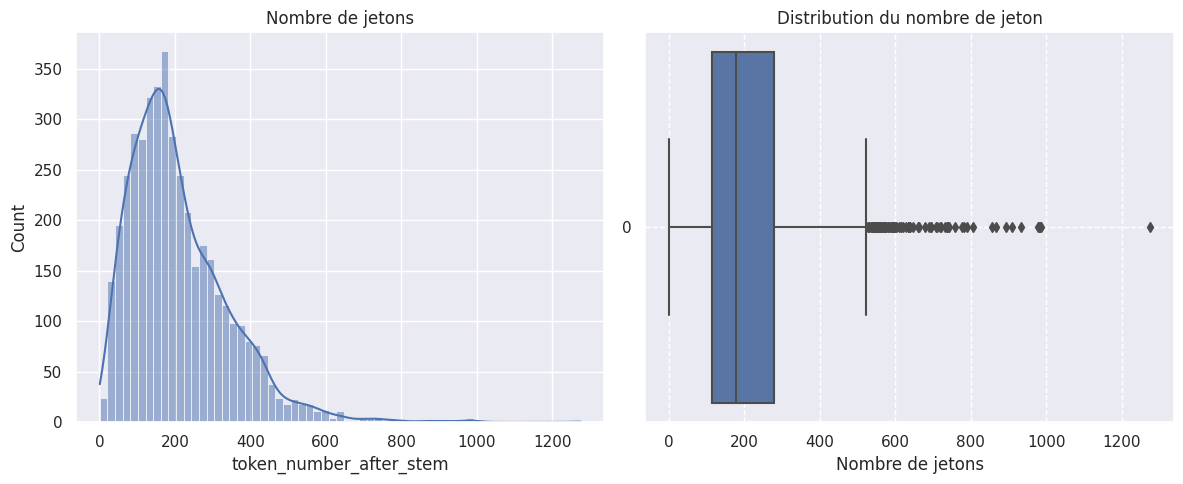

In [381]:
# Affiche l'histogramme 
plt.figure(figsize=(12, 5))

# Affiche l'histogramme et la boxplot côte à côte
plt.figure(figsize=(12, 5))

# Histogramme
plt.subplot(1, 2, 1)
sns.histplot(df_stemmed['token_number_after_stem'],kde=True,)
plt.title('Nombre de jetons')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(
    df_stemmed['token_number_after_stem'],
    orient="h",
    width=0.9,
);
plt.grid(ls='--')
plt.title('Distribution du nombre de jeton')
plt.xlabel('Nombre de jetons')

plt.tight_layout()
plt.show()

Quelques observations:
- L'histogramme semble ne pas être distribuée selon une loi normale
- Il y a de nombreux outliers

In [382]:
# Observation du jobs qui contient le plus de mot
print(df_stemmed[df_stemmed["token_number_after_stem"]==1275]['clean_title_desc_req'].iloc[0])

cnc programm cnc machinist cnc oper current sever cnc programm cnc oper cnc machinist cnc set posit avail cnc machinist set oper ref durat contract perman perman direct hire locat elk grove villag il salari shift shift hr shift shift strong set oper mill shift horizont turn machinist iii set oper lath year applic exp machin found plant toyoda okk toshiba makino mori seiki cnc machin oper ref locat carol stream il durat temp perm hire well machin oper cnc turn machin associ benefit client joint ventur world class manufactur compani manufactur steel product use automot industri applic shift shift applic prefer candid manufactur self motiv demonstr strong mechan aptitud outstand attend record enjoy fast pace work environ possess innat drive excel abl work shift abl work weekend overtim requir expect machin oper check spec load /unload product line use measur tool manual inspect part chang /adjust product tool complet product paperwork addit duti daili prevent mainten remov dispos chip /sh

***

5. **Vectorisation :** Convertir les descriptions de poste, les prérequis et les titres de poste en vecteurs numériques. Nous utiliserons la méthode TF-IDF, également connue sous le nom de normalisation, qui mesure combien de fois un mot particulier apparaît dans un seul document (TF), tout en réduisant l'importance des mots qui apparaissent fréquemment dans l'ensemble des documents (IDF).

In [383]:
# On définit le dataframee à vectoriser
df_job_final = df_jobs.copy()
df_job_final['clean_title_desc_req'] = df_stemmed['clean_title_desc_req'].copy()

# Affiche le dataset final
display(df_job_final)

#On initialise le tfidf vectorizer
Vectorizer = TfidfVectorizer()

tfidf_job_id = Vectorizer.fit_transform((df_job_final['clean_title_desc_req']))
tfidf_job_id

,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
0,75,Administrative Assistant,The Administrative Assistant must be reliable ...,Please refer to the Job Description to view th...,Houston,TX,US,77036.0,2012-03-30 01:23:57.737,2012-04-29 23:59:59,20,administr assist administr assist reliabl prof...
1,505,LAB TECH,S. Florida Medical Device Co. seeks QC Lab Tec...,General knowledge of scientific or clinical la...,Plantation,FL,US,33313.0,2012-03-23 04:48:17.063,2012-04-22 23:59:59,137,lab tech s. florida medic devic co. seek qc la...
2,764,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,Please refer to the Job Description to view th...,Des Plaines,IL,US,60018.0,2012-03-18 05:19:04.863,2012-04-17 23:59:59,59,travel season staff travel season staff cb ros...
3,766,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,Please refer to the Job Description to view th...,Chicago,IL,US,60606.0,2012-03-22 10:33:46.89,2012-04-21 23:59:59,141,market social media intern market rep cb chica...
4,781,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",Please refer to the Job Description to view th...,Schiller Park,IL,US,60176.0,2012-04-01 01:16:40.797,2012-04-30 23:59:59,4,print sale print sale experienc outsid sale pr...
...,...,...,...,...,...,...,...,...,...,...,...,...
4286,1115583,Implementation Consultant - Virtual,"<p>Luceo Solutions, LLC &nbsp;creates cloud ba...",<ul>\r <li>3+ &nbsp;years of project manage...,Chicago,IL,US,NaN,2012-03-27 15:50:52.623,2012-04-26 23:59:59,14,implement consult virtual luceo solut llc crea...
4287,1115739,Auto Finance Manager,<strong>Auto Finance Manager\r</strong>\r<p><s...,<p><strong></strong></p>\r<br />\r<ul>\r <l...,Gurnee,IL,US,60031.0,2012-04-11 16:32:03.237,2012-05-10 23:59:59,178,auto financ manag auto financ manag auto gurne...
4288,1115740,Import Auto Sales,<br />\rAuto Sales\r<p></p>\r<p>Auto Sales<spa...,<br />\r<ul>\r <li>Excellent communication ...,Schaumburg,IL,US,60173.0,2012-04-22 17:30:02.78,2012-05-21 23:59:59,178,import auto sale auto sale auto sale schaumbur...
4289,1115747,Automotive Sales / Auto Sales / New & Pre-Owne...,<br />\r<strong>Automotive Sales / Auto Sales ...,<br />\r<ul>\r <li>Demonstrated leadership ...,Libertyville,IL,US,60048.0,2012-03-26 09:45:32.863,2012-04-25 23:59:59,178,automot sale auto sale pre own car sale automo...


<4291x15468 sparse matrix of type '<class 'numpy.float64'>'
	with 560804 stored elements in Compressed Sparse Row format>

***

**Création de la fonction de prétraitement textuel**: Résumons ce que nous avons fait précédemmment en une seule fonction `text_preprocess` qui prend en entrée un DataFrame `df`, un titre de colonne `title` et deux colonnes de texte `col_text_1` et `col_text_2`. Voici ce que fait la fonction :

1. Concatène les deux colonnes de texte `col_text_1` et `col_text_2` pour former une nouvelle colonne appelée `title`.
2. Applique plusieurs transformations de prétraitement au texte :
   - `pre_text`: Une fonction pour le prétraitement initial du texte.
   - `remove_html_tags`: Supprime les balises HTML du texte.
   - `etiquetage`: Étiquette les mots dans le texte.
   - `informative_token`: Identifie les jetons informatifs dans le texte.
   - `list_token`: Convertit le texte en une liste de jetons.
   - `token_number`: Compte le nombre de jetons dans le texte.
3. Supprime les jetons contenant un seul caractère.
4. Met à jour la colonne de compte du nombre de jetons.
5. Crée une nouvelle colonne appelée `clean_title` qui contient le texte nettoyé.
6. Supprime les mots vides du texte nettoyé.
7. Applique le stemming au texte nettoyé.
8. Applique une fonction `cleaner` à la colonne `title`.
9. Renvoie le DataFrame prétraité.

In [384]:
def text_preprocess(df, title, col_text_1, col_text_2):
    df.loc[:,title] = df[col_text_1].map(str) + "  "+ df[col_text_2].map(str) 

    df = pre_text(df, title)
    df[title] = df[title].apply(remove_html_tags)
    df=etiquetage(df, title)
    df=informative_token(df)
    df=list_token(df)
    df=token_number(df)
    # Supprime les jetons contenant un seul caractère
    df["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in df["clean_token"]]

    # Mettre à jour la colonne de compte du nombre de jetons
    df_preprocess = token_number(df)
    df_preprocess.head()
    # Creer une colonne cleaned_title_desc_req qui reprends le résultat 
    df_preprocess["clean_title"] = [" ".join(x) for x in df_preprocess["clean_token"]]

    df_preprocess=remove_stopwords_df(df_preprocess, title)
    df_preprocess=apply_stemming_df(df_preprocess, title)
    df_preprocess[title]=df_preprocess[title].apply(cleaner)

    return df_preprocess

### `Modélisation initiale: Test de recommandation de Job`

Dans la suite on définit une fonction qui prend en entrée l'identifiant d'un utilisateur spécifique (UserID) et utilise les informations associées à cet utilisateur pour recommander des jobs dont les caractéristiques correspondent le mieux à cet utilisateur. En d'autres termes, elle trouve des jobs qui sont les plus similaires à la description de cet utilisateur particulier.

In [385]:
# Fusionnons le dataset df_user avec df_user_history
df_user_and_hist = pd.merge(df_users, df_users_history, on= 'UserID', how='inner')

# Choisissons le dataset avec la dernière expérience professionnelle de chaque utilisateur
df_user_and_hist = df_user_and_hist[df_user_and_hist['Sequence'] == df_user_and_hist.groupby('UserID')['Sequence'].transform('max')]

# Affiche le dataset
display(df_user_and_hist)

,UserID,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,Sequence,JobTitle,JobCategoryID
1,23,Mount Prospect,IL,US,60056,High School,Not Applicable,2002-01-01 00:00:00,3,10.0,Yes,No,0,0.0,2,Assisting customers,30.0
5,698,Normal,IL,US,61761,NaN,NaN,NaN,4,7.0,Yes,No,0,NaN,4,"Customer Service, Retail",77.0
9,2305,Lake Forest,IL,US,60045,NaN,insurance,2010-12-01 00:00:00,4,9.0,Yes,No,0,180.0,4,Project Coordinator,27.0
15,2785,Chicago,IL,US,60607,Bachelor's,International Affairs,2005-01-01 00:00:00,6,10.0,Yes,No,0,191.0,6,Event Coordinator,196.0
18,3406,Joliet,IL,US,60435,Bachelor's,English,NaN,3,20.0,No,Yes,350,40.0,3,"Programming Supervisor, Master Scheduler",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,1469336,Chicago,IL,US,60654,Bachelor's,Economics,NaN,7,22.0,Yes,No,0,0.0,7,UNIX Architect,38.0
9891,1469784,Chicago,IL,US,60647,Master's,Finance,1997-01-01 00:00:00,6,19.0,NaN,No,0,79.0,6,Staff Accountant,59.0
9895,1470222,Round Lake,IL,US,60073,Master's,Computer,NaN,4,18.0,NaN,No,0,110.0,4,Project Lead/ Sr. System Analyst,78.0
9906,1470245,Chicago,IL,US,60608,Bachelor's,Finance,1996-06-01 00:00:00,11,16.0,Yes,No,0,79.0,11,FINANCIAL ANALYST,69.0


In [386]:
# Copie du dataset
df_user_and_hist_prepro = df_user_and_hist.copy()

# On prétraite les données utilisateurs
df_user_and_hist_process = text_preprocess(df_user_and_hist, 'title_major', 'Major', 'JobTitle')

# On réarrange le dataset
df_user_and_hist_prepro['title_major'] = df_user_and_hist_process['title_major']

# Affiche le dataset prétraité
display(df_user_and_hist_prepro)


,UserID,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,Sequence,JobTitle,JobCategoryID,title_major
1,23,Mount Prospect,IL,US,60056,High School,Not Applicable,2002-01-01 00:00:00,3,10.0,Yes,No,0,0.0,2,Assisting customers,30.0,applic assist custom
5,698,Normal,IL,US,61761,NaN,NaN,NaN,4,7.0,Yes,No,0,NaN,4,"Customer Service, Retail",77.0,"nan custom servic , retail"
9,2305,Lake Forest,IL,US,60045,NaN,insurance,2010-12-01 00:00:00,4,9.0,Yes,No,0,180.0,4,Project Coordinator,27.0,insur project coordin
15,2785,Chicago,IL,US,60607,Bachelor's,International Affairs,2005-01-01 00:00:00,6,10.0,Yes,No,0,191.0,6,Event Coordinator,196.0,intern affair event coordin
18,3406,Joliet,IL,US,60435,Bachelor's,English,NaN,3,20.0,No,Yes,350,40.0,3,"Programming Supervisor, Master Scheduler",6.0,"english program supervisor , master schedul"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,1469336,Chicago,IL,US,60654,Bachelor's,Economics,NaN,7,22.0,Yes,No,0,0.0,7,UNIX Architect,38.0,econom unix architect
9891,1469784,Chicago,IL,US,60647,Master's,Finance,1997-01-01 00:00:00,6,19.0,NaN,No,0,79.0,6,Staff Accountant,59.0,financ staff account
9895,1470222,Round Lake,IL,US,60073,Master's,Computer,NaN,4,18.0,NaN,No,0,110.0,4,Project Lead/ Sr. System Analyst,78.0,comput project lead / sr. system analyst
9906,1470245,Chicago,IL,US,60608,Bachelor's,Finance,1996-06-01 00:00:00,11,16.0,Yes,No,0,79.0,11,FINANCIAL ANALYST,69.0,financ financi analyst


In [387]:
# On vectorise l'expérience des utilisateurs suivant la colonne JobTitle
users_history_tfidf = Vectorizer.transform(df_user_and_hist_prepro["title_major"])
users_history_tfidf

<2246x15468 sparse matrix of type '<class 'numpy.float64'>'
	with 9530 stored elements in Compressed Sparse Row format>

In [388]:
"""
Créer des recommandations de job par UserID
"""
def job_to_user(userid, df_tfidf):
    
    if userid in df_user_and_hist_prepro["UserID"].tolist():
        index = np.where(df_user_and_hist_prepro["UserID"] == userid)[0][:]
        user_q = df_user_and_hist_prepro.iloc[index[0]:(index[-1]+1)]
        
        print(f"Information à propos de l'emploi: {userid}")
        display(user_q)
        
        # Vectoriser la description de l'utilisateur
        user_tfidf = Vectorizer.transform(user_q["title_major"])
        
        # Calculer le score de similarité
        similarity_score = map(lambda x: linear_kernel(user_tfidf, x), df_tfidf)
        output = list(similarity_score)
        
        # Obtenir les ID des recommandations
        top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:10]
        recommendation = pd.DataFrame(columns = ["UserID", "Recommended_JobID"])
        count = 0
        
        for i in top:
            recommendation.at[count, "UserID"] = userid
            recommendation.at[count, "Recommended_JobID"] = df_job_final["JobID"].iloc[i]
            count += 1
            
            
        # Obtenir les données des utilisateurs recommandés
        nearest_jobs = recommendation["Recommended_JobID"]
        
        for jobid in nearest_jobs:
            display(df_job_final[df_job_final['JobID']==jobid])
            
        print(f"\nIdentifiant de job recommandé pour l'utilisateur {userid}\n")
        
    else:
        return ("Cet ID d'utilisateur n'est pas dans la liste des utilisateurs")

        
    return recommendation

In [389]:
# Test de la fonction avec le user 23
job_to_user(23,tfidf_job_id)

Information à propos de l'emploi: 23


,UserID,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,Sequence,JobTitle,JobCategoryID,title_major
1,23,Mount Prospect,IL,US,60056,High School,Not Applicable,2002-01-01 00:00:00,3,10.0,Yes,No,0,0.0,2,Assisting customers,30.0,applic assist custom


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
407,130956,LACK OF EXPERIENCE HURTING YOU? Sales & Custom...,"<p style=""text-align: center;""><strong>Apply a...","<strong><span style=""text-decoration: underlin...",Chicago,IL,US,60610.0,2012-03-23 12:57:53.157,2012-04-22 23:59:59,1,lack hurt sale custom servic interview entri l...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
1191,314757,Administrative Assistant,<STRONG>AAA Car Care Plus</STRONG> is recruiti...,<SPAN>\r<P><SPAN></SPAN></P>\r<BR>\r<P><SPAN>H...,Suwanee,GA,US,30024.0,2012-04-10 14:27:37.313,2012-05-09 23:59:59,20,administr assist aaa car care recruit administ...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
406,130955,LACK OF EXPERIENCE HURTING YOU? Entry Level Sa...,"<p style=""text-align: center;""><strong>Apply a...","<strong><span style=""text-decoration: underlin...",Chicago,IL,US,60610.0,2012-03-23 12:50:29.13,2012-04-22 23:59:59,48,lack hurt entri level sale market interview en...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
1547,430910,"IF THERE WAS A PROBLEM, YO I'LL SOLVE IT - Ent...","<p style=""text-align: center;""><strong>""...<sp...","<strong><span style=""text-decoration: underlin...",Chicago,IL,US,60610.0,2012-04-07 21:55:48.543,2012-05-06 23:59:59,48,problem yo solv entri level sale `` ... check ...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
3651,957725,Customer Service Representative,"<P style=""MARGIN: 0in -35pt 0pt 0in""><SPAN><ST...","<P style=""MARGIN: 0in -35pt 0pt 0in""><SPAN><ST...",Schaumburg,IL,US,NaN,2012-03-29 14:30:50.233,2012-04-28 23:59:59,1,custom servic repres descript custom servic re...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
1520,410311,Part-time Customer Service Representative,"<p align=""justify""><b>Check 'n Go </b>has been...","<p><b>Minimum Knowledge, Skills, and Abilities...",Joliet,IL,US,60435.0,2012-03-20 08:50:03.517,2012-04-19 23:59:59,1,custom servic repres check 'n go leader financ...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
3729,980295,Part-time Customer Service Representative,"<p align=""justify""><b>Check 'n Go </b>has been...","<p><b>Minimum Knowledge, Skills, and Abilities...",Delavan,WI,US,53115.0,2012-03-26 16:30:04.707,2012-04-25 23:59:59,1,custom servic repres check 'n go leader financ...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
3730,980300,Part-time Customer Service Representative,"<p align=""justify""><b>Check 'n Go </b>has been...","<p><b>Minimum Knowledge, Skills, and Abilities...",Chicago,IL,US,NaN,2012-04-02 08:34:30.127,2012-05-01 23:59:59,1,custom servic repres check 'n go leader financ...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
773,212560,Customer Service Representative,Fast growing company in downtown Chicago is lo...,QUALIFICATIONS:<br />\r<ul>\r <li>2-3 years...,Chicago,IL,US,60611.0,2012-03-30 15:49:15.133,2012-04-29 23:59:59,1,custom servic repres fast grow compani downtow...


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,clean_title_desc_req
1811,500681,Customer Service/Inside Sales Associate,"<p style=""text-align: center"" align=""center""><...",Qualified candidates are individuals who posse...,Wood Dale,IL,US,60191.0,2012-03-27 17:34:29.353,2012-04-26 23:59:59,123,custom servic sale associ custom servic sale a...



Identifiant de job recommandé pour l'utilisateur 23



,UserID,Recommended_JobID
0,23,130956
1,23,314757
2,23,130955
3,23,430910
4,23,957725
5,23,410311
6,23,980295
7,23,980300
8,23,212560
9,23,500681


Ici nous avons effectué des recommandations avec le linear kernel mais nous ne savons pas à quel point nos prédictions sont précises. Il faudrait pour cela comparer avec les données feedbacks.

***

# <p style="text-align:center;font-size:100%;">3. Prétraitement et modélisation</p>


La clusterisation peut résoudre divers problèmes dans les systèmes de recommandation, notamment en augmentant la diversité, la cohérence et la fiabilité des recommandations. Nous utiliserons notamment l'algorithme bien connu K-means, un algorithme d'apprentissage non supervisé qui organise les points de données en groupes en fonction de leurs similarités.

Nous passerons ensuite par différentes étapes :
- **Extraction des Caractéristiques** : Nous extrayons les caractéristiques TF-IDF pour obtenir une représentation des documents à un niveau élevé.
- **Réduction de Dimensionnalité** : Nous réduisons la dimensionnalité des données en utilisant TruncatedSVD pour obtenir moins de caractéristiques.
- **Modèle de Clustering** : Nous utilisons le modèle k-means pour regrouper les données en clusters et on utilisera le score de silhouette pour déterminer le nombre optimal de clusters.

En combinant ces étapes, nous espérons améliorer nos recommandations en prenant en compte la structure sous-jacente des données et en fournissant des suggestions plus précises et diversifiées.

### `Seconde Modélisation et définition des fonctions de modélisation `

Dans cette section, nous nous concentrons uniquement sur l'utilisation des données textuelles pour estimer les meilleures recommandations de postes. Pour ce faire, nous utiliserons les informations contenues dans les fichiers suivants :`user_history` avec le titre du job précédent (JobTitle) et `jobs.csv` avec le titre du poste (Title), la description (Description) et les prérequis (Requirements).

In [390]:
# Création d'un objet TfidfVectorizer avec les paramètres min_df et max_df spécifiés
tfidf_train = TfidfVectorizer(min_df=5, max_df=0.95)

# Transformation du texte des titres, descriptions et exigences d'emploi en vecteurs TF-IDF
job_tfidf = tfidf_train.fit_transform(df_job_final["clean_title_desc_req"])

# Affichage de la matrice TF-IDF résultante
job_tfidf

<4291x5101 sparse matrix of type '<class 'numpy.float64'>'
	with 544650 stored elements in Compressed Sparse Row format>

In [391]:
# Conversion de la matrice TF-IDF des emplois en une matrice dense
job_tfidf_dense = job_tfidf.todense()

# Affichage de la forme de la matrice TF-IDF des emplois
print("Shape of job TF-IDF matrix:", job_tfidf.shape)

Shape of job TF-IDF matrix: (4291, 5101)


Le code ci-dessus utilise TruncatedSVD pour réduire la dimensionnalité d'une matrice TF-IDF. Il ajuste le modèle et affiche le temps écoulé. Ensuite, il encapsule ce processus dans une fonction `dimensionality_reduction_with_tsvd()` pour une utilisation réutilisable. Enfin, il applique cette fonction à une matrice TF-IDF spécifique (`job_tfidf`) et obtient les ratios de variance expliquée. Pour sélectionner le nombre optimal de composants, la fonction `select_n_components()` itère à travers les ratios de variance expliquée de chaque composant. Introduisont en premier cette dernière.

**Aparté**: Dans notre contexte de la recommandation d'emploi, le Truncated SVD (Singular Value Decomposition) est utilisé pour réduire la dimensionnalité de la matrice des caractéristiques des emplois (par exemple, les descriptions de poste) tout en préservant les informations pertinentes pour recommander des emplois aux utilisateurs en fonction de leurs préférences et de leur historique.

In [392]:
#Crée une fonction pour sélectionner le meilleur nombre de composants
def select_n_components(var_ratio, goal_var):
    # Initialise la variance expliquée totale
    total_variance = 0.0
    
    # Initialise le nombre de composants
    n_components = 0
    
    # Pour chaque variance expliquée de chaque composant :
    for explained_variance in var_ratio:
        total_variance += explained_variance  # Ajoute la variance expliquée au total
        n_components += 1  # Ajoute un au nombre de composants
        
        # Si nous atteignons notre objectif de variance expliquée
        if total_variance >= goal_var:
            # Met fin à la boucle
            break
            
    # Retourne le nombre de composants
    return n_components

In [393]:
# Cette fonction prend une matrice TF-IDF en entrée, puis effectue une réduction de dimensionnalité
#en utilisant TruncatedSVD avec le nombre optimal de composants
def optimal_dimensionality_reduction_with_tsvd(matrix_tfidf):
    start_time = time()
    # Initialisation d'un objet TruncatedSVD avec un nombre de composants égal à un de moins que le nombre de caractéristiques de la matrice TF-IDF
    tsvd = TruncatedSVD(n_components=matrix_tfidf.shape[1] - 1)
    
    # Ajustement du modèle TruncatedSVD sur la matrice TF-IDF
    tsvd.fit(matrix_tfidf)
    
    # Calcul du temps écoulé pour la réduction dimensionnelle avec TruncatedSVD
    elapsed_time = time() - start_time
    
    # Affichage du temps écoulé pour la réduction dimensionnelle avec TruncatedSVD
    print(f"\nDimensionality reduction with TruncatedSVD done in {elapsed_time:.3f} seconds")
    
    # Obtenir la liste des ratios de variance expliquée
    tsvd_var_ratios = tsvd.explained_variance_ratio_
    
    # Trouve le nombre de composants
    opti_compo = select_n_components(tsvd_var_ratios, 0.95)
    
    # Réduction de la dimensionnalité par TruncatedSVD() avec le nombre optimal de composants
    tsvd_train = TruncatedSVD(n_components=opti_compo)
    tsvd_matrix = tsvd_train.fit_transform(matrix_tfidf)
    explained_variance = tsvd_train.explained_variance_ratio_.sum()

    print(f"Forme de la matrice : {tsvd_matrix.shape}")
    print(f"\nVariance expliquée de l'étape SVD : {explained_variance * 100:.1f}%")
    
    return tsvd_train, tsvd_matrix, opti_compo

Nous utiliserons l'algorithme K-means qui est un algorithme de clustering qui partitionne un ensemble de données en k clusters en fonction des similarités entre les points de données. Pour évaluer la qualité des clusters produits par le K-means, nous utilisons souvent le Silhouette Score.

Le Silhouette Score est une mesure de la cohésion et de la séparation des clusters. Pour chaque point de données, il calcule à quel point ce point est proche des autres points dans son propre cluster par rapport à la proximité des points dans les clusters voisins. Un score de silhouette élevé, proche de 1, indique que les points d'un cluster sont proches les uns des autres et éloignés des points des autres clusters, ce qui est souhaitable. En revanche, un score proche de -1 indique que les points d'un cluster sont mal assortis avec les points de leurs clusters voisins, ce qui suggère une mauvaise partition des données.

En utilisant le K-means avec le Silhouette Score, nous pouvons déterminer le nombre optimal de clusters pour nos données en choisissant celui qui maximise le score de silhouette. Cela nous permet de trouver une partition des données qui maximise à la fois la cohésion intra-cluster et la séparation inter-cluster.

In [394]:
# Création de la liste des valeurs d'inertie et de silhouette_score pour différents nombres de clusters
t0 = time()

wcss = []  # Liste pour stocker les valeurs de l'inertie
silhouette = []  # Liste pour stocker les valeurs de silhouette

tsvd_train, tsvd_matrix, opti_compo = optimal_dimensionality_reduction_with_tsvd(job_tfidf)

# Entraînement du modèle k_means
for i in range(5, 51, 5):
    kmeans = KMeans(n_clusters=i, init="k-means++", n_init=10, random_state=42)
    kmeans.fit(tsvd_matrix)
    wcss.append(kmeans.inertia_)  # Ajout de l'inertie à la liste
    silhouette.append(silhouette_score(tsvd_matrix, kmeans.labels_))  # Ajout du score de silhouette à la liste

print(f"\nModèle exécuté avec 20 différents nombres de clusters en {time() - t0:.3f} s")



Dimensionality reduction with TruncatedSVD done in 89.187 seconds
Forme de la matrice : (4291, 1830)

Variance expliquée de l'étape SVD : 94.9%

Modèle exécuté avec 20 différents nombres de clusters en 197.732 s


Text(0, 0.5, 'Score de silhouette')

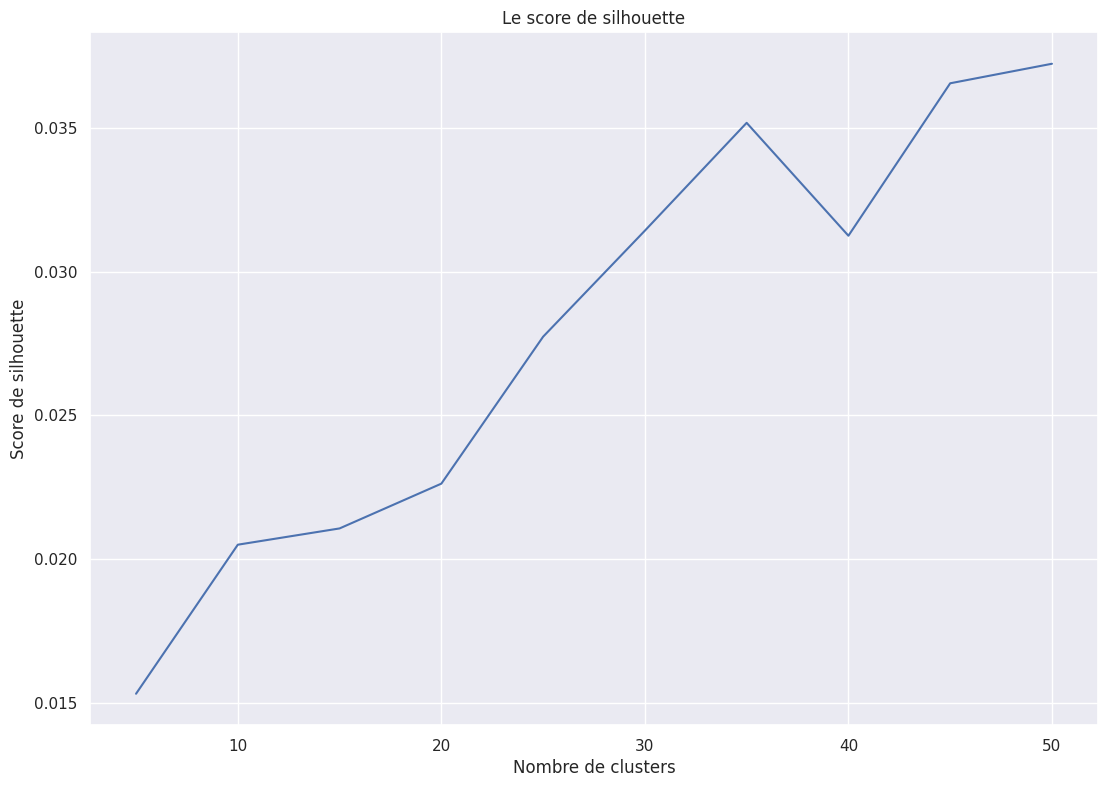

In [395]:
# Tracé du score de silhouette en fonction du nombre de clusters
plt.plot(range(5, 51, 5), silhouette)  
plt.title("Le score de silhouette")  
plt.xlabel("Nombre de clusters")  
plt.ylabel("Score de silhouette") 

In [396]:
# Trouver la valeur maximale du score de silhouette
max_score = max(silhouette)  

# Calculer le nombre optimal de clusters
optimal_clusters = silhouette.index(max_score) * 5 + 5  

# Afficher le résultat
print(f"Nombre optimal de clusters - {optimal_clusters} avec un score de silhouette de : {round(max_score, 3)}")  


Nombre optimal de clusters - 50 avec un score de silhouette de : 0.037


Quelques observations:
- On obtient un score de silhouette d'environ 0.08 ce qui indique des clusters chevauchants et donc que les échantillons prit se situent sur ou très près de la frontière de décision entre deux clusters voisins.
- La valeur la plus élevée du score de silhouette est d'environ 295 clusters (0,086). (Dans la cellule ci dessus on l'a fixé à 50 pour que ça soit plus rapide mais on a testé jusqu'à 300)


In [397]:
# Appliquer l'algorithme k-means
t0 = time()

# Initialisation et entraînement du modèle KMeans
kmeans_model = KMeans(n_clusters=280, init="k-means++", n_init=10, random_state=42)
kmeans_train = kmeans_model.fit(tsvd_matrix)
print(f"\nExécution du modèle terminée en {time() - t0:.3f} s")


Exécution du modèle terminée en 36.145 s


In [398]:
t0 = time()

# Vectorisation des données de description de l'emploi et réduction de la dimensionnalité
job_tfidf = tfidf_train.transform(df_job_final["clean_title_desc_req"])
job_svd = tsvd_train.transform(job_tfidf)

# Affichage de la forme de la matrice réduite par SVD
display(job_svd.shape)
print(f"\nVectorisation et réduction de la dimensionnalité effectuées en {time() - t0:.3f} s")

# Prédiction des clusters pour les vecteurs d'emploi en utilisant le modèle KMeans entraîné
kmeans_cluster = (kmeans_train.predict(job_svd)).tolist()
print(f"\nExécution du modèle terminée en {time() - t0:.3f} s")

(4291, 1830)


Vectorisation et réduction de la dimensionnalité effectuées en 1.412 s

Exécution du modèle terminée en 1.495 s


In [399]:
display(job_svd)

array([[ 0.17725294, -0.05234518, -0.1462248 , ..., -0.00818169,
        -0.00345832,  0.00859039],
       [ 0.18102755, -0.1159106 , -0.02918281, ..., -0.00274006,
         0.00122679, -0.00148804],
       [ 0.21714544,  0.13164395, -0.06687177, ...,  0.00716929,
        -0.01471331, -0.00586252],
       ...,
       [ 0.2489053 ,  0.21414616, -0.04219123, ..., -0.00602925,
         0.01236121, -0.01089438],
       [ 0.27244335,  0.30364401, -0.04814127, ..., -0.00196761,
        -0.00124162, -0.00627122],
       [ 0.38653344,  0.16277722, -0.0913943 , ..., -0.00251799,
         0.01084991, -0.00448559]])

In [400]:
# Examinons la forme des centres de clusters
kmeans_train.cluster_centers_.shape

(280, 1830)

In [401]:
# Ajoute les étiquettes en tant que colonne supplémentaire dans le DataFrame
df_job_final["kmeans_cluster"] = kmeans_cluster

# Affiche le nombre de documents dans chaque cluster
df_job_final["kmeans_cluster"].value_counts()

kmeans_cluster
57     91
147    64
33     61
76     60
20     53
       ..
259     2
264     2
251     2
265     2
0       2
Name: count, Length: 280, dtype: int64

Maintenant on visualise nos données en utilisant le module TSNE ou t-distributed Stochastic Neighbor Embedding qui est une technique de réduction de dimensionnalité utilisée pour visualiser des données complexes dans un espace de dimensions inférieures, généralement 2D ou 3D. Contrairement à d'autres méthodes de réduction de dimensionnalité comme PCA (Principal Component Analysis), t-SNE est particulièrement efficace pour la visualisation de données non linéaires et la préservation des structures locales.

In [402]:
def visualize_with_tsne(matrix_svd, kmeans_cluster_labels):
    """
    Réduit la dimensionnalité des données avec t-SNE et visualise les données avec les étiquettes de clusters Kmeans.

    Args:
    - matrix_svd (array): Matrice des données après la réduction de dimension avec TruncatedSVD.
    - kmeans_cluster_labels (array): Étiquettes des clusters Kmeans.

    Returns:
    - None
    """
    t0 = time()
    
    # Réduction de la dimensionnalité avec t-SNE
    tsne = TSNE(verbose=1, perplexity=50) 
    matrix_tsne = tsne.fit_transform(matrix_svd)

    print(f"\nDimensionality reduction with t-SNE done in {time() - t0:.3f} s")

    # Paramètres seaborn
    sns.set(rc={"figure.figsize":(13,9)})

    # Palette de couleurs
    palette = sns.hls_palette(20, l=.4, s=.9)

    # Plot
    sns.scatterplot(x=matrix_tsne[:,0], y=matrix_tsne[:,1], hue=kmeans_cluster_labels, legend=False, palette=palette)
    plt.title("t-SNE with Kmeans Labels")
    plt.show()

**Aparté sur la perplexité**: Le paramètre de perplexité dans t-SNE contrôle le nombre de voisins pris en compte lors de la construction de chaque point dans l'espace de faible dimension. En d'autres termes, il détermine la taille des "voisins" autour de chaque point, affectant ainsi la façon dont t-SNE interprète la structure locale des données.

- Petite perplexité : Une petite valeur de perplexité (généralement inférieure à 10) favorise la mise en évidence des détails et des structures locales. Cela peut être utile lorsque les données ont des structures locales complexes ou des clusters serrés.
- Perplexité moyenne : Une perplexité moyenne (entre 10 et 50) est souvent un bon compromis pour la plupart des ensembles de données. Cela permet de capturer à la fois les structures locales et globales des données.
- Grande perplexité : Une grande valeur de perplexité (généralement supérieure à 50) met l'accent sur les structures globales et lissées des données. Cela peut être utile lorsque les données ont des structures globales claires et qu'on veut une vue d'ensemble de l'ensemble des données.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4291 samples in 0.007s...
[t-SNE] Computed neighbors for 4291 samples in 1.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4291
[t-SNE] Computed conditional probabilities for sample 2000 / 4291
[t-SNE] Computed conditional probabilities for sample 3000 / 4291
[t-SNE] Computed conditional probabilities for sample 4000 / 4291
[t-SNE] Computed conditional probabilities for sample 4291 / 4291
[t-SNE] Mean sigma: 0.339730
[t-SNE] KL divergence after 50 iterations with early exaggeration: 80.322144
[t-SNE] KL divergence after 1000 iterations: 1.571248

Dimensionality reduction with t-SNE done in 25.020 s


/tmp/ipykernel_33/895766691.py:27: UserWarning: 
The palette list has fewer values (20) than needed (280) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=matrix_tsne[:,0], y=matrix_tsne[:,1], hue=kmeans_cluster_labels, legend=False, palette=palette)


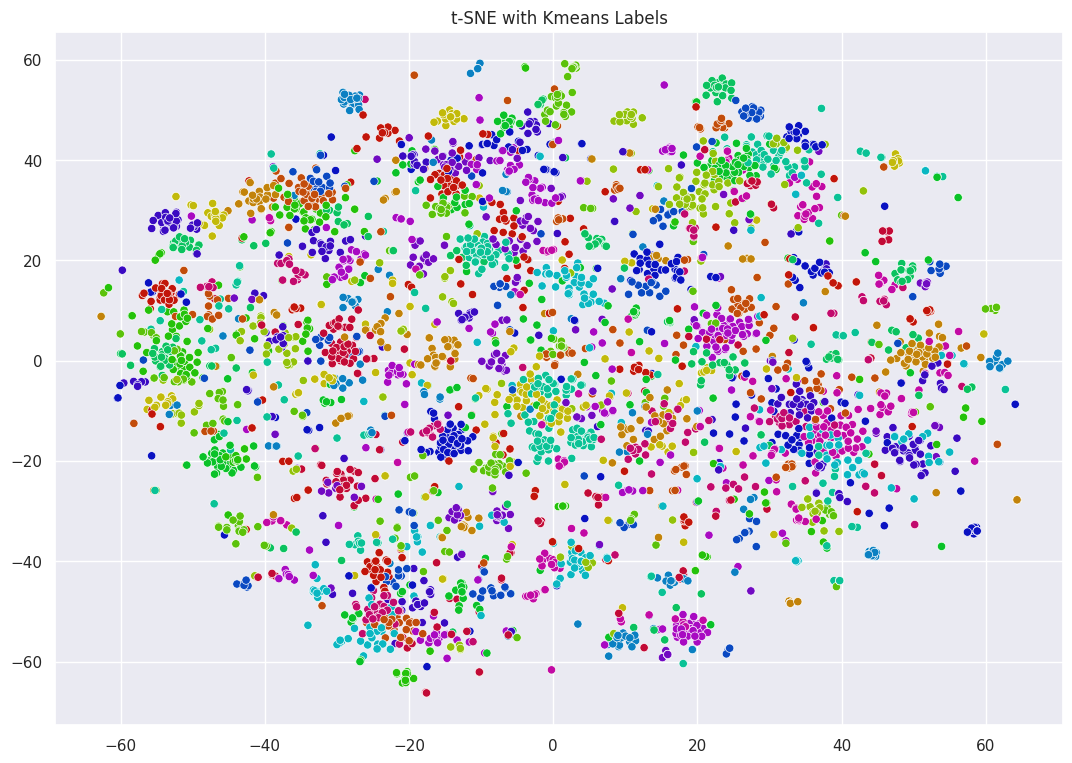

In [403]:
visualize_with_tsne(job_svd, df_job_final["kmeans_cluster"])

Le graphique précédent offre une meilleure compréhension de la façon dont les descriptions d'emploi sont regroupées, bien qu'il révèle également des clusters dispersés et de nombreux points isolés (outliers). Certaines descriptions d'emploi se chevauchent, ce qui suggère un manque de séparation claire entre les groupes. Ces observations indiquent un besoin potentiel de réduire le nombre de clusters.

Sur la base de ces résultats, il serait judicieux d'envisager de récolter plus de données et d'explorer l'utilisation d'un nombre moins élevé de clusters.

In [404]:
# Copie des données
df_users = data_users.copy()
df_users_history = data_users_history.copy()
df_test_users = data_test_users.copy()
df_jobs = data_jobs.copy()
df_feedbacks = data_feedbacks.copy()

In [405]:
# Fusionnons le dataset df_user avec df_user_history
df_user_and_hist = pd.merge(df_users, df_users_history, on= 'UserID', how='inner')

# Choisissons le dataset avec la dernière expérience professionnelle de chaque utilisateur
df_user_and_hist = df_user_and_hist[df_user_and_hist['Sequence'] == df_user_and_hist.groupby('UserID')['Sequence'].transform('max')]

# Affiche le dataset
display(df_user_and_hist)

,UserID,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,Sequence,JobTitle,JobCategoryID
1,23,Mount Prospect,IL,US,60056,High School,Not Applicable,2002-01-01 00:00:00,3,10.0,Yes,No,0,0.0,2,Assisting customers,30.0
5,698,Normal,IL,US,61761,NaN,NaN,NaN,4,7.0,Yes,No,0,NaN,4,"Customer Service, Retail",77.0
9,2305,Lake Forest,IL,US,60045,NaN,insurance,2010-12-01 00:00:00,4,9.0,Yes,No,0,180.0,4,Project Coordinator,27.0
15,2785,Chicago,IL,US,60607,Bachelor's,International Affairs,2005-01-01 00:00:00,6,10.0,Yes,No,0,191.0,6,Event Coordinator,196.0
18,3406,Joliet,IL,US,60435,Bachelor's,English,NaN,3,20.0,No,Yes,350,40.0,3,"Programming Supervisor, Master Scheduler",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,1469336,Chicago,IL,US,60654,Bachelor's,Economics,NaN,7,22.0,Yes,No,0,0.0,7,UNIX Architect,38.0
9891,1469784,Chicago,IL,US,60647,Master's,Finance,1997-01-01 00:00:00,6,19.0,NaN,No,0,79.0,6,Staff Accountant,59.0
9895,1470222,Round Lake,IL,US,60073,Master's,Computer,NaN,4,18.0,NaN,No,0,110.0,4,Project Lead/ Sr. System Analyst,78.0
9906,1470245,Chicago,IL,US,60608,Bachelor's,Finance,1996-06-01 00:00:00,11,16.0,Yes,No,0,79.0,11,FINANCIAL ANALYST,69.0


In [406]:
def text_preprocess_onecol(df, title, col_text_1):
    df.loc[:,title] = df[col_text_1].map(str) 

    df = pre_text(df, title)
    df[title] = df[title].apply(remove_html_tags)
    df=etiquetage(df, title)
    df=informative_token(df)
    df=list_token(df)
    df=token_number(df)
    # Supprime les jetons contenant un seul caractère
    df["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in df["clean_token"]]

    # Mettre à jour la colonne de compte du nombre de jetons
    df_preprocess = token_number(df)
    df_preprocess.head()
    # Creer une colonne cleaned_title_desc_req qui reprends le résultat 
    df_preprocess["clean_title"] = [" ".join(x) for x in df_preprocess["clean_token"]]

    df_preprocess=remove_stopwords_df(df_preprocess, title)
    df_preprocess=apply_stemming_df(df_preprocess, title)
    df_preprocess[title]=df_preprocess[title].apply(cleaner)

    return df_preprocess

In [407]:
# Copie du dataset
df_user_and_hist_prepro = df_user_and_hist.copy()

# On prétraite les données utilisateurs
df_user_and_hist_process = text_preprocess_onecol(df_user_and_hist_prepro, 'previous_jobtitle', 'JobTitle')

# On réarrange le dataset
df_user_and_hist_prepro['previous_jobtitle'] = df_user_and_hist_process['previous_jobtitle']

# On selectionne seulement la variablee title et userid

df_user_and_hist_prepro = df_user_and_hist_prepro[['UserID', 'previous_jobtitle']]

# On retire les valeurs manquantes
df_user_and_hist_prepro.dropna(inplace=True)

# Affiche le dataset prétraité
display(df_user_and_hist_prepro)

/tmp/ipykernel_33/3919567353.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_and_hist_prepro.dropna(inplace=True)


,UserID,previous_jobtitle
1,23,assist custom
5,698,"custom servic , retail"
9,2305,project coordin
15,2785,event coordin
18,3406,"program supervisor , master schedul"
...,...,...
9885,1469336,unix architect
9891,1469784,staff account
9895,1470222,project lead / sr. system analyst
9906,1470245,financi analyst


In [408]:
# Crée une copie du DataFrame contenant les données des utilisateurs et de leur historique
users_for_kmeans = df_user_and_hist_prepro.copy()

# Affiche les cinq premières lignes du DataFrame
users_for_kmeans.head()

,UserID,previous_jobtitle
1,23,assist custom
5,698,"custom servic , retail"
9,2305,project coordin
15,2785,event coordin
18,3406,"program supervisor , master schedul"


In [409]:
"""
Prédire le modèle k-means et obtenir les clusters pour l'ensemble des données des utilisateurs
"""
# Vectoriser
users_tfidf = tfidf_train.transform(users_for_kmeans["previous_jobtitle"])
users_svd = tsvd_train.transform(users_tfidf)

# Créer des clusters
users_cluster = kmeans_train.predict(users_svd).tolist()

users_for_kmeans["kmeans_cluster"] = users_cluster
display(users_for_kmeans.head())

,UserID,previous_jobtitle,kmeans_cluster
1,23,assist custom,18
5,698,"custom servic , retail",94
9,2305,project coordin,109
15,2785,event coordin,179
18,3406,"program supervisor , master schedul",29


In [410]:
def job_to_user_kmeans(user_id):
    # Vérifie si l'ID utilisateur est présent dans la liste des utilisateurs
    if user_id in users_for_kmeans["UserID"].tolist():
        # Récupère les données de l'utilisateur
        index = np.where(users_for_kmeans["UserID"] == user_id)[0][:]
        user_data = users_for_kmeans.iloc[index[0]:(index[-1]+1)]
        
        # Obtient le numéro de cluster de l'utilisateur
        cluster_num = user_data["kmeans_cluster"].iloc[0]
        
        print(f"Informations sur l'utilisateur: {user_id}")
        display(user_data)
        print(f"Cet utilisateur appartient au cluster: {cluster_num}")
        
        # Obtient les emplois associés au même cluster
        cluster_jobs = df_job_final[df_job_final["kmeans_cluster"] == cluster_num]
        
        # Sélectionne les 10 premiers emplois du même cluster
        recommended_jobs = cluster_jobs.head(10)
        
        # Affiche les emplois recommandés
        print("\nEmplois recommandés pour l'utilisateur:")
        for _, row in recommended_jobs.iterrows():
            display(row)
        
        print(f"\nEmplois recommandés pour l'utilisateur {user_id}\n")
        
    else:
        return "Cet identifiant utilisateur n'est pas dans la liste des utilisateurs"

    
# Exemple d'utilisation
job_to_user_kmeans(23)  


Informations sur l'utilisateur: 23


,UserID,previous_jobtitle,kmeans_cluster
1,23,assist custom,18


Cet utilisateur appartient au cluster: 18

Emplois recommandés pour l'utilisateur:


JobID                                                               17914
Title                                                     Account Manager
Description             <DIV>\r<P style="TEXT-ALIGN: center"><SPAN>Den...
Requirements            <P><SPAN style="TEXT-DECORATION: underline">Qu...
City                                                          Lincolnwood
State                                                                  IL
Country                                                                US
Zip5                                                              60712.0
StartDate                                           2012-03-24 17:23:56.7
EndDate                                               2012-04-23 23:59:59
JobCategoryID                                                         192
clean_title_desc_req    account manag dental technolog inc. seek high ...
kmeans_cluster                                                         18
Name: 87, dtype: object

JobID                                                               47341
Title                               Inside Sales Customer Service Manager
Description             <p><b>Inside Sales/Customer Service Manager<br...
Requirements            <p></p>\r<ul>\r    <li>Bachelors degree or the...
City                                                           Glen Ellyn
State                                                                  IL
Country                                                                US
Zip5                                                                  NaN
StartDate                                         2012-03-29 16:52:37.097
EndDate                                               2012-04-28 23:59:59
JobCategoryID                                                         123
clean_title_desc_req    sale custom servic manag sale /custom servic m...
kmeans_cluster                                                         18
Name: 187, dtype: object

JobID                                                               59598
Title                                               Home Electronic Sales
Description             ESSENTIAL FUNCTION:\r\nThe basic function of t...
Requirements            MINIMUM QUALIFICATIONS AND SKILLS:\r\n•Flexibl...
City                                                         Crystal Lake
State                                                                  IL
Country                                                                US
Zip5                                                              60014.0
StartDate                                         2012-03-28 02:37:06.647
EndDate                                               2012-04-27 23:59:59
JobCategoryID                                                         151
clean_title_desc_req    home electron sale essenti function basic func...
kmeans_cluster                                                         18
Name: 215, dtype: object

JobID                                                               59599
Title                               Wireless and Computer Sales Associate
Description             ESSENTIAL FUNCTION:\r\nThe basic function of t...
Requirements            MINIMUM QUALIFICATIONS AND SKILLS:\r\n•\tFlexi...
City                                                           Naperville
State                                                                  IL
Country                                                                US
Zip5                                                              60540.0
StartDate                                          2012-03-28 02:37:11.86
EndDate                                               2012-04-27 23:59:59
JobCategoryID                                                         154
clean_title_desc_req    wireless comput sale associ essenti function b...
kmeans_cluster                                                         18
Name: 216, dtype: object

JobID                                                               83739
Title                                                    Customer Service
Description             A growing company in the South Suburbs is addi...
Requirements                                             Customer Service
City                                                              Chicago
State                                                                  IL
Country                                                                US
Zip5                                                              60638.0
StartDate                                         2012-03-20 16:40:26.173
EndDate                                               2012-04-19 23:59:59
JobCategoryID                                                           1
clean_title_desc_req    custom servic grow compani south suburb ad cus...
kmeans_cluster                                                         18
Name: 295, dtype: object

JobID                                                              130955
Title                   LACK OF EXPERIENCE HURTING YOU? Entry Level Sa...
Description             <p style="text-align: center;"><strong>Apply a...
Requirements            <strong><span style="text-decoration: underlin...
City                                                              Chicago
State                                                                  IL
Country                                                                US
Zip5                                                              60610.0
StartDate                                          2012-03-23 12:50:29.13
EndDate                                               2012-04-22 23:59:59
JobCategoryID                                                          48
clean_title_desc_req    lack hurt entri level sale market interview en...
kmeans_cluster                                                         18
Name: 406, dtype: object

JobID                                                              130956
Title                   LACK OF EXPERIENCE HURTING YOU? Sales & Custom...
Description             <p style="text-align: center;"><strong>Apply a...
Requirements            <strong><span style="text-decoration: underlin...
City                                                              Chicago
State                                                                  IL
Country                                                                US
Zip5                                                              60610.0
StartDate                                         2012-03-23 12:57:53.157
EndDate                                               2012-04-22 23:59:59
JobCategoryID                                                           1
clean_title_desc_req    lack hurt sale custom servic interview entri l...
kmeans_cluster                                                         18
Name: 407, dtype: object

JobID                                                              212560
Title                                     Customer Service Representative
Description             Fast growing company in downtown Chicago is lo...
Requirements            QUALIFICATIONS:<br />\r<ul>\r    <li>2-3 years...
City                                                              Chicago
State                                                                  IL
Country                                                                US
Zip5                                                              60611.0
StartDate                                         2012-03-30 15:49:15.133
EndDate                                               2012-04-29 23:59:59
JobCategoryID                                                           1
clean_title_desc_req    custom servic repres fast grow compani downtow...
kmeans_cluster                                                         18
Name: 773, dtype: object

JobID                                                              278367
Title                                        Customer Care Representative
Description             <p style="text-align: justify"><b><span>About ...
Requirements            <strong>EDUCATION/EXPERIENCE: <br />\r</strong...
City                                                              Lombard
State                                                                  IL
Country                                                                US
Zip5                                                              60148.0
StartDate                                         2012-03-30 16:50:10.287
EndDate                                               2012-04-29 23:59:59
JobCategoryID                                                          52
clean_title_desc_req    custom care repres unit seat mobil lead provid...
kmeans_cluster                                                         18
Name: 1046, dtype: object

JobID                                                              279238
Title                                         Customer Service Specialist
Description             <hr>\r<p align="center"><strong>Customer Servi...
Requirements            <p><span> </span></p>\r<ul>\r    <li>Bachelor’...
City                                                             Elmhurst
State                                                                  IL
Country                                                                US
Zip5                                                                  NaN
StartDate                                         2012-04-16 10:23:42.117
EndDate                                               2012-05-15 23:59:59
JobCategoryID                                                           1
clean_title_desc_req    custom servic specialist custom servic special...
kmeans_cluster                                                         18
Name: 1053, dtype: object


Emplois recommandés pour l'utilisateur 23



### `Troisieme Modélisation `

Dans cette section, nous utiliserons tous les datasets excepté feedbacks.csv pour estimer les meilleures recommandations de postes.

In [411]:
# Copie des données
df_users = data_users.copy()
df_users_history = data_users_history.copy()
df_jobs = data_jobs.copy()

In [412]:
# Affiche les datasets
display(df_users.head())
display(df_users_history.head())

,UserID,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID
0,23,Mount Prospect,IL,US,60056,High School,Not Applicable,2002-01-01 00:00:00,3,10.0,Yes,No,0,0.0
1,698,Normal,IL,US,61761,NaN,NaN,NaN,4,7.0,Yes,No,0,NaN
2,2305,Lake Forest,IL,US,60045,NaN,insurance,2010-12-01 00:00:00,4,9.0,Yes,No,0,180.0
3,2785,Chicago,IL,US,60607,Bachelor's,International Affairs,2005-01-01 00:00:00,6,10.0,Yes,No,0,191.0
4,3406,Joliet,IL,US,60435,Bachelor's,English,NaN,3,20.0,No,Yes,350,40.0


,UserID,Sequence,JobTitle,JobCategoryID
0,23,1,Manager,0.0
1,23,2,Assisting customers,30.0
2,698,1,Advocate Bromenn,88.0
3,698,2,"Customer Service, Patient contact, drawing blood",135.0
4,698,3,"Customer Service, Suggestive selling",1.0


### Imputation

L'imputation des données est une étape essentielle du processus de prétraitement des données, visant à gérer les valeurs manquantes ou incorrectes.

In [413]:
# On retire les colonnes States, Country et ZipCode (puisque il y a trop de valeurs
# manquante dans Zip5 de jobs) de users
df_users.drop(['Country','State', 'ZipCode'], axis=1, inplace=True)

# On filtre les lignes correspondant à l'Illinois et retire les colonnes Country, State et Zip5 
# et start date et enddate de df_jobs_final 
df_jobs = df_jobs[df_jobs['State'] == 'IL'].drop(['Country', 'State', 'Zip5', 'StartDate', 'EndDate'], axis=1)

In [414]:
# On retire les valeurs manquantes de users
df_users.dropna(inplace=True)
df_users = df_users[df_users['Major']!='Not Applicable']
display(df_users)

,UserID,City,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID
3,2785,Chicago,Bachelor's,International Affairs,2005-01-01 00:00:00,6,10.0,Yes,No,0,191.0
5,4182,Burbank,Associate's,Administrative Assistant,2011-12-01 00:00:00,3,4.0,Yes,No,0,20.0
14,10562,Montgomery,Associate's,General Education,2008-01-01 00:00:00,2,6.0,Yes,No,0,131.0
15,11060,Oak Brook,Bachelor's,"Computer Engineering, General",1991-01-01 00:00:00,6,17.0,No,No,0,110.0
16,11400,Chicago,Bachelor's,History/Research Intelligence Analysis Program...,1999-01-01 00:00:00,10,13.0,Yes,No,0,98.0
...,...,...,...,...,...,...,...,...,...,...,...
2327,1468470,Ringwood,Associate's,Marketing Management,1992-01-01 00:00:00,2,30.0,No,No,0,23.0
2329,1468879,Belleville,Bachelor's,Business Management,2012-12-01 00:00:00,5,17.0,Yes,Yes,10,21.0
2330,1469183,Naperville,Bachelor's,Computer Science and Mathematics,1981-01-01 00:00:00,6,30.0,Yes,Yes,187,98.0
2334,1470245,Chicago,Bachelor's,Finance,1996-06-01 00:00:00,11,16.0,Yes,No,0,79.0


In [415]:
# Fusionnons le dataset df_user avec df_user_history
df_user_and_hist = pd.merge(df_users, df_users_history, on= 'UserID', how='inner')

# Choisissons le dataset avec la dernière expérience professionnelle de chaque utilisateur
df_user_and_hist = df_user_and_hist[df_user_and_hist['Sequence'] == df_user_and_hist.groupby('UserID')['Sequence'].transform('max')]

# Affiche le dataset
display(df_user_and_hist)

,UserID,City,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,Sequence,JobTitle,JobCategoryID
5,2785,Chicago,Bachelor's,International Affairs,2005-01-01 00:00:00,6,10.0,Yes,No,0,191.0,6,Event Coordinator,196.0
7,4182,Burbank,Associate's,Administrative Assistant,2011-12-01 00:00:00,3,4.0,Yes,No,0,20.0,2,Crew Team,150.0
9,10562,Montgomery,Associate's,General Education,2008-01-01 00:00:00,2,6.0,Yes,No,0,131.0,2,Retail Sales Representative & Book Keeper,77.0
14,11060,Oak Brook,Bachelor's,"Computer Engineering, General",1991-01-01 00:00:00,6,17.0,No,No,0,110.0,5,Territory Manager,0.0
20,11400,Chicago,Bachelor's,History/Research Intelligence Analysis Program...,1999-01-01 00:00:00,10,13.0,Yes,No,0,98.0,9,Competitive Intelligence Analyst,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,1468470,Ringwood,Associate's,Marketing Management,1992-01-01 00:00:00,2,30.0,No,No,0,23.0,2,Strategic Sourcing Specialist/Purchasing Agent...,145.0
3957,1468879,Belleville,Bachelor's,Business Management,2012-12-01 00:00:00,5,17.0,Yes,Yes,10,21.0,5,"Team Leader, Transentric",33.0
3963,1469183,Naperville,Bachelor's,Computer Science and Mathematics,1981-01-01 00:00:00,6,30.0,Yes,Yes,187,98.0,6,SALES MANAGEMENT AND MARKETING MANAGEMENT POSI...,17.0
3974,1470245,Chicago,Bachelor's,Finance,1996-06-01 00:00:00,11,16.0,Yes,No,0,79.0,11,FINANCIAL ANALYST,69.0


In [416]:
# Retirons pour le moment la colonnes graduation date et séquence
df_user_and_hist.drop(['GraduationDate', 'Sequence'], axis=1, inplace=True)

### Encodage des données

Nous allons encoder les données de la même manière que dans le notebook de l'analyse exploratoire.

In [417]:
# Créer un dictionnaire pour mapper les catégories de 'DegreeType' avec des variables entières
degree_type_mapping = {'vocational': 0, 'High School': 1, "Associate's": 2, "Bachelor's": 3, "Master's": 4, 'PhD': 5}

# Appliquer le mapping à la colonne 'DegreeType'
df_user_and_hist['DegreeType'] = df_user_and_hist['DegreeType'].map(degree_type_mapping)

# Mappez les événements 'No' à 0 et 'Yes' à 1 pour la colonne 'CurrentlyEmployed'
df_user_and_hist['CurrentlyEmployed'] = df_user_and_hist['CurrentlyEmployed'].map({'No': 0, 'Yes': 1})

# Mappez les événements 'No' à 0 et 'Yes' à 1 pour la colonne 'ManagedOthers'
df_user_and_hist['ManagedOthers'] = df_user_and_hist['ManagedOthers'].map({'No': 0, 'Yes': 1})

# Sélectionner uniquement les colonnes numériques
numeric_columns = df_user_and_hist.select_dtypes(include='number').dropna(axis=0)

# Affiche le dataset 
display(df_user_and_hist)

,UserID,City,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobTitle,JobCategoryID
5,2785,Chicago,3.0,International Affairs,6,10.0,1,0,0,191.0,Event Coordinator,196.0
7,4182,Burbank,2.0,Administrative Assistant,3,4.0,1,0,0,20.0,Crew Team,150.0
9,10562,Montgomery,2.0,General Education,2,6.0,1,0,0,131.0,Retail Sales Representative & Book Keeper,77.0
14,11060,Oak Brook,3.0,"Computer Engineering, General",6,17.0,0,0,0,110.0,Territory Manager,0.0
20,11400,Chicago,3.0,History/Research Intelligence Analysis Program...,10,13.0,1,0,0,98.0,Competitive Intelligence Analyst,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3952,1468470,Ringwood,2.0,Marketing Management,2,30.0,0,0,0,23.0,Strategic Sourcing Specialist/Purchasing Agent...,145.0
3957,1468879,Belleville,3.0,Business Management,5,17.0,1,1,10,21.0,"Team Leader, Transentric",33.0
3963,1469183,Naperville,3.0,Computer Science and Mathematics,6,30.0,1,1,187,98.0,SALES MANAGEMENT AND MARKETING MANAGEMENT POSI...,17.0
3974,1470245,Chicago,3.0,Finance,11,16.0,1,0,0,79.0,FINANCIAL ANALYST,69.0


### Standardisation

Pour standardiser la colonne "TotalYearsExperience", nous pouvons utiliser différentes techniques, mais l'une des approches les plus courantes est la standardisation z-score. Cela implique de soustraire la moyenne de la colonne à chaque valeur, puis de diviser par l'écart-type. 

In [418]:
from sklearn.preprocessing import StandardScaler

# Créer un objet StandardScaler
scaler = StandardScaler()

# Sélectionner la colonne TotalYearsExperience et la transformer en une série 1D pour la standardisation
total_years_exp = df_user_and_hist['TotalYearsExperience'].values.reshape(-1, 1)

# Appliquer la standardisation z-score à la colonne TotalYearsExperience
total_years_exp_standardized = scaler.fit_transform(total_years_exp)

# Remplacer la colonne d'origine par la version standardisée
df_user_and_hist['TotalYearsExperience'] = total_years_exp_standardized

# Affiche le dataset
display(df_user_and_hist)

,UserID,City,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobTitle,JobCategoryID
5,2785,Chicago,3.0,International Affairs,6,-0.242174,1,0,0,191.0,Event Coordinator,196.0
7,4182,Burbank,2.0,Administrative Assistant,3,-0.972060,1,0,0,20.0,Crew Team,150.0
9,10562,Montgomery,2.0,General Education,2,-0.728765,1,0,0,131.0,Retail Sales Representative & Book Keeper,77.0
14,11060,Oak Brook,3.0,"Computer Engineering, General",6,0.609360,0,0,0,110.0,Territory Manager,0.0
20,11400,Chicago,3.0,History/Research Intelligence Analysis Program...,10,0.122769,1,0,0,98.0,Competitive Intelligence Analyst,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3952,1468470,Ringwood,2.0,Marketing Management,2,2.190780,0,0,0,23.0,Strategic Sourcing Specialist/Purchasing Agent...,145.0
3957,1468879,Belleville,3.0,Business Management,5,0.609360,1,1,10,21.0,"Team Leader, Transentric",33.0
3963,1469183,Naperville,3.0,Computer Science and Mathematics,6,2.190780,1,1,187,98.0,SALES MANAGEMENT AND MARKETING MANAGEMENT POSI...,17.0
3974,1470245,Chicago,3.0,Finance,11,0.487712,1,0,0,79.0,FINANCIAL ANALYST,69.0


### Traitement des données textuelles de ce dataset

On prétraite les colonnes Major et JobTitle grâce à la fonction text_preprocess introduite précédemment.

#### Données utilisateurs

In [419]:
# On redéfinit la fonction de traitement pour introduire la colonne City
def text_preprocess3(df, title, col_text_1, col_text_2, col_text_3):
    df.loc[:,title] = df[col_text_1].map(str) + "  "+ df[col_text_2].map(str) + "  "+ df[col_text_3].map(str) 

    df = pre_text(df, title)
    df[title] = df[title].apply(remove_html_tags)
    df=etiquetage(df, title)
    df=informative_token(df)
    df=list_token(df)
    df=token_number(df)
    # Supprime les jetons contenant un seul caractère
    df["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in df["clean_token"]]

    # Mettre à jour la colonne de compte du nombre de jetons
    df_preprocess = token_number(df)
    df_preprocess.head()
    # Creer une colonne cleaned_title_desc_req qui reprends le résultat 
    df_preprocess["clean_title"] = [" ".join(x) for x in df_preprocess["clean_token"]]

    df_preprocess=remove_stopwords_df(df_preprocess, title)
    df_preprocess=apply_stemming_df(df_preprocess, title)
    df_preprocess[title]=df_preprocess[title].apply(cleaner)

    return df_preprocess

In [420]:
# On prétraite les données City, Major et JobTitle
df_user_hist_pre = text_preprocess3(df_user_and_hist, 'city_major_job','City', 'Major', 'JobTitle')

# Affiche le dataset
display(df_user_hist_pre.head())

,UserID,City,DegreeType,Major,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobTitle,JobCategoryID,city_major_job,POS,POS_clean,clean_token,token_number,clean_title
5,2785,Chicago,3.0,International Affairs,6,-0.242174,1,0,0,191.0,Event Coordinator,196.0,chicago intern affair event coordin,"[(chicago, JJ), (international, JJ), (affairs,...","[(chicago, JJ), (international, JJ), (affairs,...","[chicago, international, affairs, event, coord...",5,chicago international affairs event coordinator
7,4182,Burbank,2.0,Administrative Assistant,3,-0.972060,1,0,0,20.0,Crew Team,150.0,burbank administr assist crew team,"[(burbank, NN), (administrative, JJ), (assista...","[(burbank, NN), (administrative, JJ), (assista...","[burbank, administrative, assistant, crew, team]",5,burbank administrative assistant crew team
9,10562,Montgomery,2.0,General Education,2,-0.728765,1,0,0,131.0,Retail Sales Representative & Book Keeper,77.0,montgomeri gener educ retail sale repres & boo...,"[(montgomery, NN), (general, JJ), (education, ...","[(montgomery, NN), (general, JJ), (education, ...","[montgomery, general, education, retail, sales...",8,montgomery general education retail sales repr...
14,11060,Oak Brook,3.0,"Computer Engineering, General",6,0.609360,0,0,0,110.0,Territory Manager,0.0,"oak brook comput engin , gener territori manag","[(oak, NN), (brook, NN), (computer, NN), (engi...","[(oak, NN), (brook, NN), (computer, NN), (engi...","[oak, brook, computer, engineering, general, t...",7,oak brook computer engineering general territo...
20,11400,Chicago,3.0,History/Research Intelligence Analysis Program...,10,0.122769,1,0,0,98.0,Competitive Intelligence Analyst,9.0,chicago histori esearch intellig analysi progr...,"[(chicago, JJ), (history, NN), (esearch, NN), ...","[(chicago, JJ), (history, NN), (esearch, NN), ...","[chicago, history, esearch, intelligence, anal...",11,chicago history esearch intelligence analysis ...


In [421]:
# Enleve les colonnes qui nee sont pas utiles
df_user_and_hist.drop(['City', 'Major', 'JobTitle','POS','POS_clean','clean_token','token_number','clean_title'], axis=1, inplace=True)

# Affichage du DataFrame mis à jour
display(df_user_and_hist.head())

,UserID,DegreeType,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobCategoryID,city_major_job
5,2785,3.0,6,-0.242174,1,0,0,191.0,196.0,chicago intern affair event coordin
7,4182,2.0,3,-0.972060,1,0,0,20.0,150.0,burbank administr assist crew team
9,10562,2.0,2,-0.728765,1,0,0,131.0,77.0,montgomeri gener educ retail sale repres & boo...
14,11060,3.0,6,0.609360,0,0,0,110.0,0.0,"oak brook comput engin , gener territori manag"
20,11400,3.0,10,0.122769,1,0,0,98.0,9.0,chicago histori esearch intellig analysi progr...


#### Données jobs

In [422]:
# On redéfinit la fonction de traitement pour introduire la colonne City
def text_preprocess4(df, title, col_text_1, col_text_2, col_text_3, col_text_4):
    df.loc[:,title] = df[col_text_1].map(str) + "  "+ df[col_text_2].map(str) + "  "+ df[col_text_3].map(str)+"  "+ df[col_text_4].map(str) 

    df = pre_text(df, title)
    df[title] = df[title].apply(remove_html_tags)
    df=etiquetage(df, title)
    df=informative_token(df)
    df=list_token(df)
    df=token_number(df)
    # Supprime les jetons contenant un seul caractère
    df["clean_token"] = [[subelt for subelt in elt if len(subelt) > 1] for elt in df["clean_token"]]

    # Mettre à jour la colonne de compte du nombre de jetons
    df_preprocess = token_number(df)
    df_preprocess.head()
    # Creer une colonne cleaned_title_desc_req qui reprends le résultat 
    df_preprocess["clean_title"] = [" ".join(x) for x in df_preprocess["clean_token"]]

    df_preprocess=remove_stopwords_df(df_preprocess, title)
    df_preprocess=apply_stemming_df(df_preprocess, title)
    df_preprocess[title]=df_preprocess[title].apply(cleaner)

    return df_preprocess

In [423]:
# On prétraite les données City, Major et JobTitle
df_job_pre = text_preprocess4(df_jobs, 'city_title_desc_req','City', 'Title', 'Description','Requirements')

# Affiche le dataset
display(df_job_pre.head())

,JobID,Title,Description,Requirements,City,JobCategoryID,city_title_desc_req,POS,POS_clean,clean_token,token_number,clean_title
2,764,Travel-Seasonal Staff,<p>Travel-Seasonal Staff </p> <p> CB331736 Ros...,Please refer to the Job Description to view th...,Des Plaines,59,de plain travel season staff travel season sta...,"[(des, NNS), (plaines, NNS), (travel, VBP), (s...","[(des, NNS), (plaines, NNS), (travel, VBP), (s...","[des, plaines, travel, seasonal, staff, travel...",96,des plaines travel seasonal staff travel seaso...
3,766,MARKETING/ Social Media intern,<p>Marketing Rep </p> <p> CB326227 Chicago </p...,Please refer to the Job Description to view th...,Chicago,141,chicago market / social media intern market re...,"[(chicago, NN), (marketing, NN), (/, NNP), (so...","[(chicago, NN), (marketing, NN), (/, NNP), (so...","[chicago, marketing, social, media, intern, ma...",162,chicago marketing social media intern marketin...
4,781,Printing Sales,"<p>Printing Sales Experienced, outside sales w...",Please refer to the Job Description to view th...,Schiller Park,4,schiller park print sale print sale experienc ...,"[(schiller, NN), (park, NN), (printing, VBG), ...","[(schiller, NN), (park, NN), (printing, VBG), ...","[schiller, park, printing, sales, printing, sa...",27,schiller park printing sales printing sales ex...
5,782,QUALITY TECHNICIAN,Elgin ddeno@mprplastics.com QUALITY TECHNICIAN...,Please refer to the Job Description to view th...,Elgin,60,elgin qualiti technician elgin ddeno @mprplast...,"[(elgin, NN), (quality, NN), (technician, JJ),...","[(elgin, NN), (quality, NN), (technician, JJ),...","[elgin, quality, technician, elgin, ddeno, mpr...",65,elgin quality technician elgin ddeno mprplasti...
6,796,Machinist & CNC Operator,CB326858 Machinist & CNC Operator; Carpentersv...,- 5 years of experience on machines equipped w...,Carpentersville,139,carpentersvil machinist & cnc oper cb 3 2 6 8 ...,"[(carpentersville, NNS), (machinist, VBP), (&,...","[(carpentersville, NNS), (machinist, VBP), (cn...","[carpentersville, machinist, cnc, operator, cb...",90,carpentersville machinist cnc operator cb mach...


In [424]:
# Enleve les colonnes qui nee sont pas utiles
df_job_pre.drop(['City', 'Title', 'Description','Requirements','POS','POS_clean','clean_token','token_number','clean_title'], axis=1, inplace=True)

# Affichage du DataFrame mis à jour
display(df_job_pre.head())

,JobID,JobCategoryID,city_title_desc_req
2,764,59,de plain travel season staff travel season sta...
3,766,141,chicago market / social media intern market re...
4,781,4,schiller park print sale print sale experienc ...
5,782,60,elgin qualiti technician elgin ddeno @mprplast...
6,796,139,carpentersvil machinist & cnc oper cb 3 2 6 8 ...


### Vectorisation

#### Données jobs

In [425]:
# Création d'un objet TfidfVectorizer avec les paramètres min_df et max_df spécifiés
tfidf_train = TfidfVectorizer(min_df=5, max_df=0.95)

# Transformation du texte des titres, descriptions et exigences d'emploi en vecteurs TF-IDF
job_tfidf = tfidf_train.fit_transform(df_job_pre["city_title_desc_req"])

# Affichage de la matrice TF-IDF résultante
print(job_tfidf.shape)

(3532, 5703)


In [426]:
optimal_dimensionality_reduction_with_tsvd(job_tfidf)


Dimensionality reduction with TruncatedSVD done in 62.791 seconds
Forme de la matrice : (3532, 1746)

Variance expliquée de l'étape SVD : 94.9%


(TruncatedSVD(n_components=1746),
 array([[ 2.15667258e-01, -1.76788507e-03,  1.22953920e-01, ...,
         -2.41400146e-03, -2.24728926e-02,  2.50870459e-02],
        [ 1.97853863e-01, -2.58220977e-02,  1.00467692e-02, ...,
          1.13290480e-02, -6.69531965e-03,  5.11945636e-03],
        [ 1.33512271e-01,  2.27782517e-02,  2.35249997e-01, ...,
          5.22930392e-03, -4.23356465e-03,  1.99056143e-02],
        ...,
        [ 2.47971537e-01,  1.51602427e-02,  2.12137024e-01, ...,
          6.85246089e-03, -2.94877104e-03, -5.14111104e-03],
        [ 2.76899618e-01,  2.02252654e-02,  3.11164436e-01, ...,
          1.64868362e-02,  5.47655157e-03,  1.80781703e-02],
        [ 3.70422604e-01, -3.86524752e-02,  1.62627027e-01, ...,
          8.90151730e-03,  2.14912877e-02, -7.14962747e-05]]),
 1746)

In [427]:
# Création de la liste des valeurs d'inertie et de silhouette_score pour différents nombres de clusters
t0 = time()

wcss = []  # Liste pour stocker les valeurs de l'inertie
silhouette = []  # Liste pour stocker les valeurs de silhouette

tsvd_train, tsvd_matrix, opti_compo = optimal_dimensionality_reduction_with_tsvd(job_tfidf)

# Entraînement du modèle k_means
for i in range(5, 51, 5):
    kmeans = KMeans(n_clusters=i, init="k-means++", n_init=10, random_state=42)
    kmeans.fit(tsvd_matrix)
    wcss.append(kmeans.inertia_)  # Ajout de l'inertie à la liste
    silhouette.append(silhouette_score(tsvd_matrix, kmeans.labels_))  # Ajout du score de silhouette à la liste

print(f"\nModèle exécuté avec 20 différents nombres de clusters en {time() - t0:.3f} s")



Dimensionality reduction with TruncatedSVD done in 63.491 seconds
Forme de la matrice : (3532, 1746)

Variance expliquée de l'étape SVD : 94.9%

Modèle exécuté avec 20 différents nombres de clusters en 153.070 s


Text(0, 0.5, 'Score de silhouette')

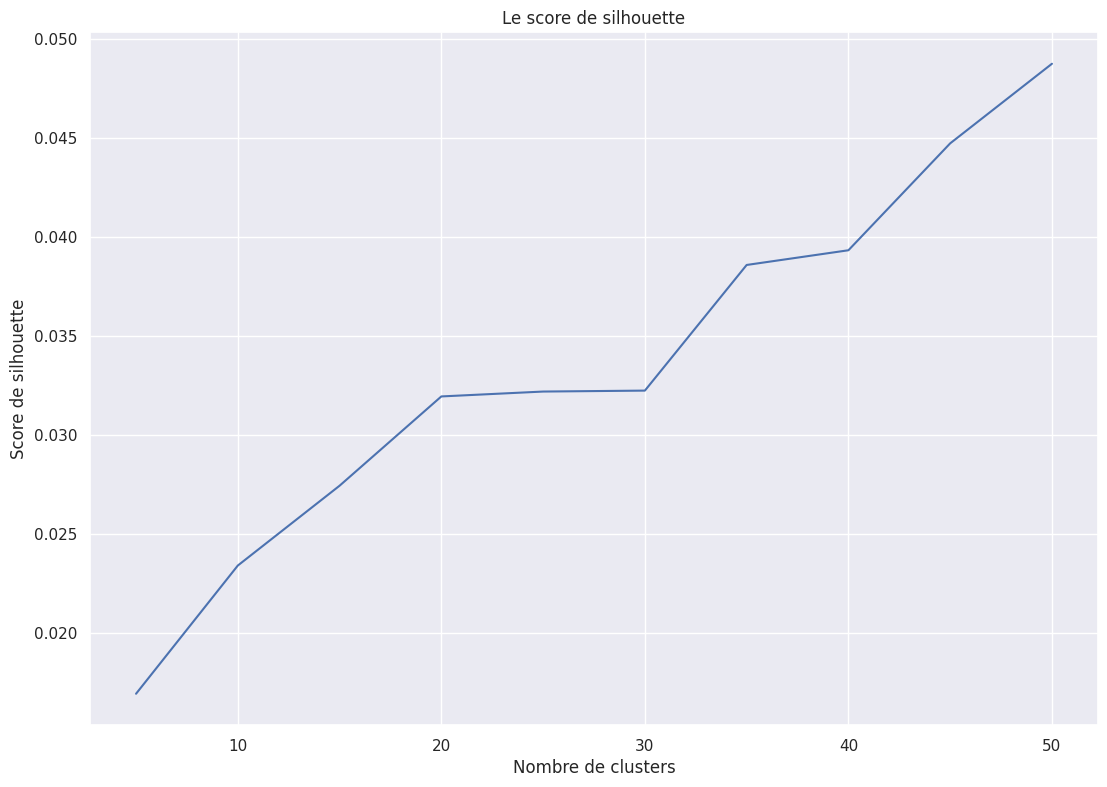

In [428]:
# Tracé du score de silhouette en fonction du nombre de clusters
plt.plot(range(5, 51, 5), silhouette)  
plt.title("Le score de silhouette")  
plt.xlabel("Nombre de clusters")  
plt.ylabel("Score de silhouette") 

In [429]:
# Trouver la valeur maximale du score de silhouette
max_score = max(silhouette)  

# Calculer le nombre optimal de clusters
optimal_clusters = silhouette.index(max_score) * 5 + 5  

# Afficher le résultat
print(f"Nombre optimal de clusters - {optimal_clusters} avec un score de silhouette de : {round(max_score, 3)}")  

Nombre optimal de clusters - 50 avec un score de silhouette de : 0.049


In [430]:
# Appliquer l'algorithme k-means
t0 = time()

# Initialisation et entraînement du modèle KMeans
kmeans_model = KMeans(n_clusters=45, init="k-means++", n_init=10, random_state=42)
kmeans_train = kmeans_model.fit(tsvd_matrix)
print(f"\nExécution du modèle terminée en {time() - t0:.3f} s")


Exécution du modèle terminée en 8.543 s


In [431]:
t0 = time()

# Vectorisation des données de description de l'emploi et réduction de la dimensionnalité
job_tfidf = tfidf_train.transform(df_jobs["city_title_desc_req"])
job_svd = tsvd_train.transform(job_tfidf)

# Affichage de la forme de la matrice réduite par SVD
display(job_svd.shape)
print(f"\nVectorisation et réduction de la dimensionnalité effectuées en {time() - t0:.3f} s")

(3532, 1746)


Vectorisation et réduction de la dimensionnalité effectuées en 1.350 s


In [432]:
# Prédiction des clusters pour les vecteurs d'emploi en utilisant le modèle KMeans entraîné
kmeans_cluster = (kmeans_train.predict(job_svd)).tolist()
print(f"\nExécution du modèle terminée en {time() - t0:.3f} s")


Exécution du modèle terminée en 1.378 s


In [433]:
display(job_svd)

array([[ 2.15667258e-01, -1.76788507e-03,  1.22953920e-01, ...,
        -1.08705171e-02, -3.15142685e-03, -9.12198018e-04],
       [ 1.97853863e-01, -2.58220977e-02,  1.00467692e-02, ...,
        -7.55382320e-03, -9.58522545e-03, -2.96267327e-03],
       [ 1.33512271e-01,  2.27782517e-02,  2.35249997e-01, ...,
        -7.50552151e-03,  1.07355431e-02, -2.87759634e-03],
       ...,
       [ 2.47971537e-01,  1.51602427e-02,  2.12137024e-01, ...,
         1.55394894e-02, -9.73651285e-03, -3.45231344e-03],
       [ 2.76899618e-01,  2.02252654e-02,  3.11164436e-01, ...,
         2.79849275e-04, -1.03298051e-02,  1.02756312e-02],
       [ 3.70422604e-01, -3.86524752e-02,  1.62627027e-01, ...,
        -3.42123869e-03, -6.74436628e-03,  3.22262469e-03]])

In [434]:
# Examinons la forme des centres de clusters
kmeans_train.cluster_centers_.shape

(45, 1746)

In [435]:
# Ajoute les étiquettes en tant que colonne supplémentaire dans le DataFrame
df_jobs["kmeans_cluster"] = kmeans_cluster

# Affiche le nombre de documents dans chaque cluster
df_jobs["kmeans_cluster"].value_counts()

kmeans_cluster
29    384
1     233
24    222
30    152
32    151
19    139
38    134
28    133
11    132
2     123
4     109
12    107
16     91
15     90
3      86
7      81
18     79
35     75
44     74
17     72
5      71
14     64
43     64
37     59
0      55
34     51
39     50
22     47
36     45
9      40
13     38
6      35
8      32
25     28
31     27
20     22
40     22
23     22
10     20
27     18
21     15
33     13
42     11
26     10
41      6
Name: count, dtype: int64

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3532 samples in 0.006s...
[t-SNE] Computed neighbors for 3532 samples in 0.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3532
[t-SNE] Computed conditional probabilities for sample 2000 / 3532
[t-SNE] Computed conditional probabilities for sample 3000 / 3532
[t-SNE] Computed conditional probabilities for sample 3532 / 3532
[t-SNE] Mean sigma: 0.336505
[t-SNE] KL divergence after 50 iterations with early exaggeration: 77.816551
[t-SNE] KL divergence after 1000 iterations: 1.544416

Dimensionality reduction with t-SNE done in 20.494 s


/tmp/ipykernel_33/895766691.py:27: UserWarning: 
The palette list has fewer values (20) than needed (45) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=matrix_tsne[:,0], y=matrix_tsne[:,1], hue=kmeans_cluster_labels, legend=False, palette=palette)


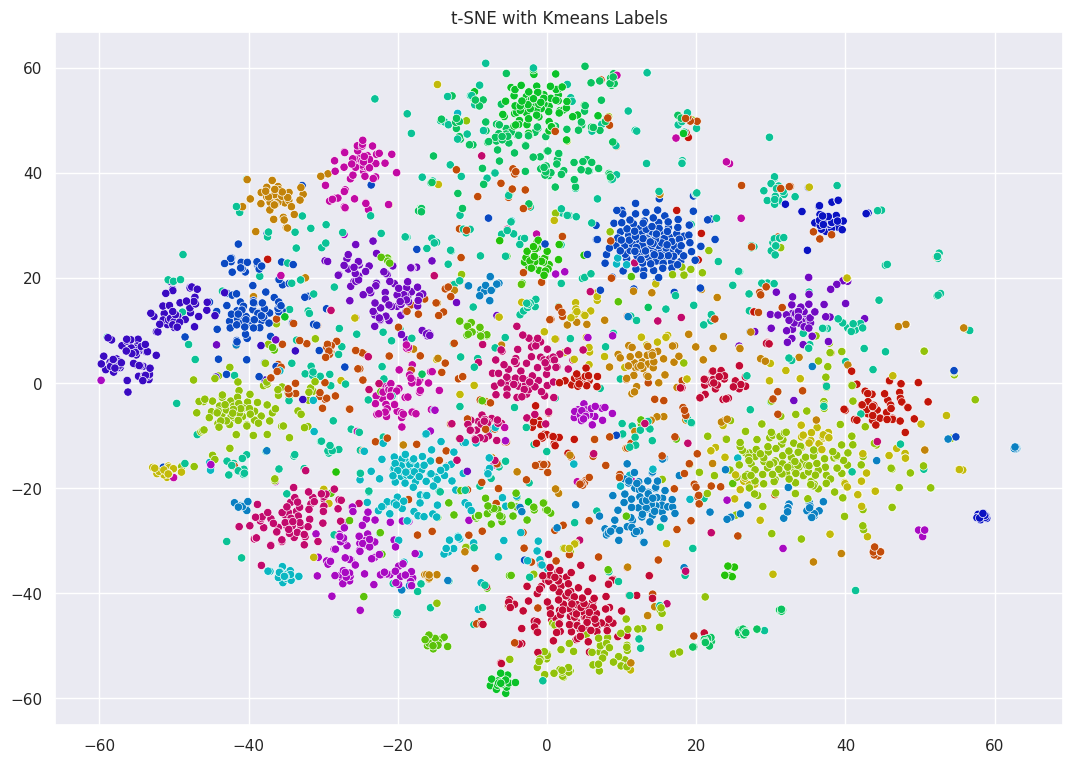

In [436]:
visualize_with_tsne(job_svd, df_jobs["kmeans_cluster"])

Ici on observe plus distinctement les clusters de jobs à recommander, bon signe ! On observe encore beaucoup de jobs qui se disperse (bleu turquoise) et quelques outliers.

#### Données utilisateurs

In [437]:
# Crée une copie du DataFrame contenant les données des utilisateurs et de leur historique
users_for_kmeans = df_user_and_hist.copy()

# Affiche les cinq premières lignes du DataFrame
users_for_kmeans.head()

,UserID,DegreeType,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobCategoryID,city_major_job
5,2785,3.0,6,-0.242174,1,0,0,191.0,196.0,chicago intern affair event coordin
7,4182,2.0,3,-0.972060,1,0,0,20.0,150.0,burbank administr assist crew team
9,10562,2.0,2,-0.728765,1,0,0,131.0,77.0,montgomeri gener educ retail sale repres & boo...
14,11060,3.0,6,0.609360,0,0,0,110.0,0.0,"oak brook comput engin , gener territori manag"
20,11400,3.0,10,0.122769,1,0,0,98.0,9.0,chicago histori esearch intellig analysi progr...


In [438]:
"""
Prédire le modèle k-means et obtenir les clusters pour l'ensemble des données des utilisateurs
"""
# Vectoriser
users_tfidf = tfidf_train.transform(users_for_kmeans["city_major_job"])
users_svd = tsvd_train.transform(users_tfidf)

# Créer des clusters
users_cluster = kmeans_train.predict(users_svd).tolist()

users_for_kmeans["kmeans_cluster"] = users_cluster
display(users_for_kmeans.head())

    
# Exemple d'utilisation
job_to_user_kmeans(2785)  

,UserID,DegreeType,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobCategoryID,city_major_job,kmeans_cluster
5,2785,3.0,6,-0.242174,1,0,0,191.0,196.0,chicago intern affair event coordin,29
7,4182,2.0,3,-0.972060,1,0,0,20.0,150.0,burbank administr assist crew team,38
9,10562,2.0,2,-0.728765,1,0,0,131.0,77.0,montgomeri gener educ retail sale repres & boo...,29
14,11060,3.0,6,0.609360,0,0,0,110.0,0.0,"oak brook comput engin , gener territori manag",4
20,11400,3.0,10,0.122769,1,0,0,98.0,9.0,chicago histori esearch intellig analysi progr...,29


Informations sur l'utilisateur: 2785


,UserID,DegreeType,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany,MajorCategoryID,JobCategoryID,city_major_job,kmeans_cluster
5,2785,3.0,6,-0.242174,1,0,0,191.0,196.0,chicago intern affair event coordin,29


Cet utilisateur appartient au cluster: 29

Emplois recommandés pour l'utilisateur:


JobID                                                               31030
Title                                        Scientist - Prod Development
Description             Scientist-Product Development\r\n\r\n Glatfelt...
Requirements            Please refer to the Job Description to view th...
City                                                          Chillicothe
State                                                                  OH
Country                                                                US
Zip5                                                              45601.0
StartDate                                          2012-04-15 00:42:38.55
EndDate                                               2012-05-14 23:59:59
JobCategoryID                                                          58
clean_title_desc_req    scientist prod develop scientist product devel...
kmeans_cluster                                                         29
Name: 124, dtype: object

JobID                                                               44451
Title                                          Component Lab Technician I
Description             <strong><em><p align="left">Job Summary</p></e...
Requirements            Please refer to the Job Description for the qu...
City                                                               Peoria
State                                                                  IL
Country                                                                US
Zip5                                                              61605.0
StartDate                                         2012-04-03 01:44:48.063
EndDate                                               2012-05-02 23:59:59
JobCategoryID                                                         137
clean_title_desc_req    compon lab technician summari manufactur store...
kmeans_cluster                                                         29
Name: 175, dtype: object

JobID                                                              101163
Title                                                   Intern-Regulatory
Description             <p><span>Sensient Colors LLC is seeking a Summ...
Requirements            We are looking for someone majoring in Chemist...
City                                                          Saint Louis
State                                                                  MO
Country                                                                US
Zip5                                                              63106.0
StartDate                                         2012-04-13 17:34:40.913
EndDate                                               2012-05-12 23:59:59
JobCategoryID                                                          36
clean_title_desc_req    intern regulatori sensient color llc seek summ...
kmeans_cluster                                                         29
Name: 344, dtype: object

JobID                                                              179827
Title                                   Production Supervisor - 2nd Shift
Description             <ol>\r    <li>\r    <div align="left"><span> S...
Requirements            1.    High school diploma required. TMA/PMA tr...
City                                                    Arlington Heights
State                                                                  IL
Country                                                                US
Zip5                                                              60005.0
StartDate                                         2012-04-17 12:00:16.027
EndDate                                               2012-05-16 23:59:59
JobCategoryID                                                         120
clean_title_desc_req    product supervisor shift select work center au...
kmeans_cluster                                                         29
Name: 607, dtype: object

JobID                                                              198215
Title                                                       CNC Machinist
Description             <div align="left"><div align="center"></div>\r...
Requirements            <p></p>\r<p><b><span>Education/Experience:</sp...
City                                                               Itasca
State                                                                  IL
Country                                                                US
Zip5                                                              60143.0
StartDate                                         2012-04-12 16:27:02.913
EndDate                                               2012-05-11 23:59:59
JobCategoryID                                                         139
clean_title_desc_req    cnc machinist summari oper coordin measur equi...
kmeans_cluster                                                         29
Name: 683, dtype: object

JobID                                                              200298
Title                                           Curative Title Associates
Description             <p style="text-align: center" align="center">&...
Requirements            <strong>Requirements:<br />\r</strong>\r<ul>\r...
City                                                          Saint Louis
State                                                                  MO
Country                                                                US
Zip5                                                                  NaN
StartDate                                         2012-03-26 17:05:42.587
EndDate                                               2012-04-25 23:59:59
JobCategoryID                                                           0
clean_title_desc_req    cur titl associ cur titl associ larg financi i...
kmeans_cluster                                                         29
Name: 694, dtype: object

JobID                                                              206520
Title                                                   FILLING OPERATORS
Description             This entry level position of  Filling Operator...
Requirements                                                          NaN
City                                                        South Holland
State                                                                  IL
Country                                                                US
Zip5                                                                  NaN
StartDate                                         2012-04-10 12:42:01.823
EndDate                                               2012-05-09 23:59:59
JobCategoryID                                                         122
clean_title_desc_req    fill oper entri level fill oper fill approv cu...
kmeans_cluster                                                         29
Name: 729, dtype: object

JobID                                                              206934
Title                           Packer (Short-Term) $9.00 3:30pm-Midnight
Description             Job duties:\r\n1. Follow all sanitation and al...
Requirements                                                             
City                                                         Carol Stream
State                                                                  IL
Country                                                                US
Zip5                                                                  NaN
StartDate                                         2012-04-23 18:17:17.447
EndDate                                               2012-05-22 23:59:59
JobCategoryID                                                           0
clean_title_desc_req    packer short term midnight duti sanit allergen...
kmeans_cluster                                                         29
Name: 733, dtype: object

JobID                                                              219991
Title                                   Floating Copy and Mail Specialist
Description             <P><U><STRONG>POSITION PROFILE</STRONG></U><BR...
Requirements            <LI>Requires high school diploma plus 6-12 mon...
City                                                             Rockford
State                                                                  IL
Country                                                                US
Zip5                                                                  NaN
StartDate                                         2012-03-19 10:47:50.263
EndDate                                               2012-04-18 23:59:59
JobCategoryID                                                           3
clean_title_desc_req    float copi mail specialist profil support dail...
kmeans_cluster                                                         29
Name: 806, dtype: object

JobID                                                              249238
Title                                                       FINANCIAL AID
Description             oSTAND FOR CERTAIN PERIODS OF THE DAY.        ...
Requirements                                                          NaN
City                                                             Elmhurst
State                                                                  IL
Country                                                                US
Zip5                                                              60126.0
StartDate                                          2012-04-02 14:44:32.24
EndDate                                               2012-05-01 23:59:59
JobCategoryID                                                          69
clean_title_desc_req    financi aid ostand certain period day osit lon...
kmeans_cluster                                                         29
Name: 917, dtype: object


Emplois recommandés pour l'utilisateur 2785



Les recommandations ont l'air de bien fonctionner mais on pourrait surement faire mieux en rajoutant le reste des caractéristiques des utilisateurs.

### `Idée de modélisation avec les données feedbacks`

Dans cette étape, nous nous servirons seulement d'une partie des données: les données feedbacks.

In [449]:
df_jobs = data_jobs.copy()
df_users=data_users.copy()
df_users_history = data_users_history.copy()

In [450]:
# Identifier les UserID et JobID embauchés
hired_users_jobs = df_feedbacks[df_feedbacks['Event'] == 'hired']

# Identifier les UserID et JobID postulé
applied_users_jobs = df_feedbacks[df_feedbacks['Event'] == 'applied']

# Identifier les UserID et JobID vues
viewed_users_jobs = df_feedbacks[df_feedbacks['Event'] == 'viewed']

# Créer un masque booléen pour identifier les index des lignes à conserver dans applied_users_jobs
indices_to_keep = ~applied_users_jobs.set_index(['UserID', 'JobID']).index.isin(hired_users_jobs.set_index(['UserID', 'JobID']).index)

# Appliquer le masque pour filtrer les lignes
applied_not_hired = applied_users_jobs[indices_to_keep]

# Identifier les UserID et JobID justes vues
viewed_not_hired_applied = viewed_users_jobs[~viewed_users_jobs.set_index(['UserID', 'JobID']).index.isin(hired_users_jobs.set_index(['UserID', 'JobID']).index) & ~viewed_users_jobs.set_index(['UserID', 'JobID']).index.isin(applied_users_jobs.set_index(['UserID', 'JobID']).index)]

# Concaténer les DataFrames en une seule DataFrame
merged_data = pd.concat([hired_users_jobs, applied_not_hired, viewed_not_hired_applied], axis=0)


# Mappez les événements 'viewed', 'applied' à 1 et 'hired' à 2
merged_data['Event'] = merged_data['Event'].map({'viewed':1,'applied': 2, 'hired': 3})

In [451]:
# Création de mappage d'ideentifiant
def generate_id_mapping(ids_list):
    userID_map = {new_id: old_id for new_id, old_id in enumerate(ids_list)}
    inverse_userID_map = {old_id: new_id for new_id, old_id in enumerate(ids_list)}
    return userID_map, inverse_userID_map

# Générer des mappages d'identifiants utilisateur en utilisant la fonction generate_id_mapping
userID_map, inverse_userID_map = generate_id_mapping(merged_data.UserID.unique())

# Générer des mappages d'identifiants d'emploi en utilisant la fonction generate_id_mapping
jobID_map, inverse_jobID_map = generate_id_mapping(merged_data.JobID.unique())

# Mapper les anciens identifiants d'utilisateur aux nouveaux identifiants et ajouter une colonne 'mUserID' à merged_data
merged_data['mUserID'] = merged_data['UserID'].map(inverse_userID_map)

# Mapper les anciens identifiants d'emploi aux nouveaux identifiants et ajouter une colonne 'mJobID' à merged_data
merged_data['mJobID'] = merged_data['JobID'].map(inverse_jobID_map)

# Créer une table de pivot à partir de merged_data où les lignes sont les nouveaux identifiants d'utilisateur,
# les colonnes sont les nouveaux identifiants d'emploi et les valeurs sont les événements associés,
# remplissant les valeurs manquantes avec 0
pivot_event = merged_data.pivot(index='mUserID', columns='mJobID', values='Event').fillna(0)

# Afficher la table de pivot
display(pivot_event)


mJobID,0,1,2,3,4,5,6,7,8,9,...,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148
mUserID,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
1857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [452]:
# Convertir la table de pivot en une matrice NumPy
matrix_pivot_event = pivot_event.values

# Calculer la moyenne des événements par utilisateur
user_event_mean = np.mean(matrix_pivot_event, axis=1)

# Soustraire la moyenne des événements par utilisateur de chaque valeur dans la matrice
matrix_pivot_event_diff = matrix_pivot_event - user_event_mean.reshape(-1,1)

In [453]:
# Spécifier la dimension latente
latent_dimension = 15

# Effectuer la décomposition en valeurs singulières (SVD) sur la matrice pivot des événements différenciée
U, sigma, Vt = svds(matrix_pivot_event_diff, k=latent_dimension)

# Afficher les dimensions des matrices résultantes
print("Dimension de U :", U.shape)
print("Dimension de sigma :", sigma.shape)
print("Dimension de Vt :", Vt.shape)

Dimension de U : (1861, 15)
Dimension de sigma : (15,)
Dimension de Vt : (15, 3149)


In [454]:
# Créer une matrice diagonale à partir du vecteur sigma
sigma = np.diag(sigma)

# Calculer la racine carrée de la matrice diagonale sigma
sigma_root = sqrtm(sigma)

# Calculer le produit matriciel entre U et la racine carrée de sigma
usk = np.dot(U, sigma_root)

# Calculer le produit matriciel entre la racine carrée de sigma et Vt
skv = np.dot(sigma_root, Vt)

In [455]:
# Prédire les événements en effectuant le produit matriciel entre USK et SKV
predicted_event = np.dot(usk, skv)

# Ajouter la moyenne des événements par utilisateur à chaque valeur prédite
predicted_event = predicted_event + user_event_mean.reshape(-1, 1)

In [456]:
# Créer un DataFrame à partir de la matrice d'événements prédits avec les colonnes correspondant aux nouveaux identifiants d'emploi
pred_df = pd.DataFrame(predicted_event, columns=pivot_event.columns)

# Afficher le DataFrame contenant les événements prédits
display(pred_df)


mJobID,0,1,2,3,4,5,6,7,8,9,...,3139,3140,3141,3142,3143,3144,3145,3146,3147,3148
0,0.019761,0.015455,0.006146,0.003330,0.003731,0.007577,0.007758,0.015861,0.026656,0.065063,...,0.005429,0.005920,0.004991,0.005048,0.005048,0.004971,0.004651,0.005865,0.004195,0.004234
1,-0.000499,0.030075,-0.001467,0.007458,0.005223,0.001848,0.001652,0.005793,0.000534,0.017800,...,-0.000213,-0.000119,-0.000244,0.001168,0.001168,0.000790,0.002354,0.001174,-0.000039,-0.000185
2,0.002293,0.005686,0.013747,-0.003719,-0.000865,0.004540,0.004830,0.003742,-0.006369,-0.015562,...,0.007253,0.006929,0.007239,0.005213,0.005213,0.005694,0.004279,0.004508,0.005251,0.005067
3,0.012959,0.000927,0.000450,0.016401,0.012331,0.003658,0.004505,0.004351,-0.003280,-0.001154,...,0.003212,0.003382,0.003048,0.003449,0.003449,0.003317,0.004086,0.004266,0.003970,0.003872
4,-0.002332,0.009023,0.003381,0.007966,0.007927,0.004319,0.003774,0.003367,-0.007249,-0.011643,...,0.003345,0.003263,0.003472,0.003829,0.003829,0.003755,0.003792,0.004037,0.003800,0.003893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,0.020312,0.016140,0.005310,0.002135,0.003129,0.004791,0.004115,0.003270,-0.016762,-0.021503,...,0.004562,0.004382,0.004699,0.005073,0.005073,0.004965,0.003972,0.004100,0.003768,0.003706
1857,0.003384,-0.007280,0.004969,0.001285,0.002449,0.000382,0.001183,0.004279,0.005139,0.006481,...,0.000136,0.000170,-0.000117,0.000754,0.000754,0.000936,0.001387,0.000730,0.001826,0.001950
1858,0.005821,0.001328,0.003060,0.005418,0.005091,0.005171,0.005045,0.002626,-0.002981,-0.003835,...,0.003799,0.003843,0.003943,0.004049,0.004049,0.004022,0.004020,0.004870,0.003902,0.003915
1859,-0.008500,-0.008887,0.002611,0.006113,0.005929,0.001460,0.001307,-0.000695,0.000981,-0.017828,...,0.001981,0.001845,0.002238,0.002093,0.002093,0.002310,0.002361,0.002278,0.003508,0.003587


In [457]:
# Définition d'une fonction qui recommande des jobs en utilisant seulement le dataset précédent

def recommend_jobs(pred_df, userID, df_jobs, df_original_event, num_reco):
    # Mappez UserID inverse pour obtenir l'ID réel
    mUserID = inverse_userID_map[userID]
    sorted_user_predictions = pred_df.iloc[mUserID].sort_values(ascending=False)
    
    # Récupérer les infos sur les UserID et JobID dans original_event_df
    user_data = df_original_event[df_original_event.UserID == userID]
    user_full = user_data.merge(df_jobs, how='left', on='JobID').sort_values(by='Event', ascending=False)[['JobID', 'Title']]
    
    print(f"Le User {userID} a déjà consulté {user_full.shape[0]} jobs.")
    
    # Recommander les jobs qui favorisent l'embauche
    recommendation = (df_jobs[~df_jobs['JobID'].isin(user_full['JobID'])].
        merge(pd.DataFrame(sorted_user_predictions).reset_index(), how='left', 
              left_on = 'mJobID',
              right_on='mJobID').
        rename(columns={mUserID:'Predictions'}).
        sort_values('Predictions', ascending=False).
                        iloc[:num_reco, :-1]
                        )
    
    return user_full, recommendation


In [458]:
# Mapper les anciens identifiants d'emploi aux nouveaux identifiants et ajouter une colonne 'mJobID' à df_jobs
df_jobs['mJobID'] = df_jobs['JobID'].map(inverse_jobID_map)


In [459]:
# Itérer sur les deux premiers utilisateurs dans le dictionnaire inverse_userID_map
for user in list(inverse_userID_map.keys())[:2]:
    # Appeler la fonction recommend_jobs pour obtenir les emplois déjà consultés et les prédictions pour les emplois recommandés
    already_consult, predictions = recommend_jobs(pred_df, user, df_jobs, merged_data, 10)
    
    # Afficher les emplois déjà consultés par l'utilisateur
    display(already_consult)
    
    # Afficher les prédictions pour les emplois recommandés à l'utilisateur
    display(predictions)


Le User 2305 a déjà consulté 13 jobs.


,JobID,Title
0,925011,Entry Level Sales
1,317319,EXTERNAL MARKETING COORDINATOR
2,1051415,Front Desk / Customer Service-WAUKEGAN
3,925327,Inside Sales Temp to Hire-$14-$18/hour
4,854431,RF Engineer - Multiple locations
5,852315,Outside Sales/Lead Generator
6,46841,Administrative Assistant in Staffing Department
7,1055037,Client Service Coordinator
8,573231,Help Desk Technician
9,173609,"Technician - 1st Shift, Fulltime with benefits"


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,mJobID
2744,749238,Administrative Assistant,"<strong><span style=""text-decoration: underlin...",<ul>\r <li>Exceptional oral & written commu...,Lombard,IL,US,60148.0,2012-03-20 13:38:38.007,2012-04-19 23:59:59,20,122.0
3140,837446,Entry-Level Secretary/Receptionist,"We are seeking an outgoing, detail-oriented Pa...",Job requirements include:\r•\tCompetent profic...,Chicago,IL,US,60631.0,2012-04-11 11:11:22.667,2012-05-10 23:59:59,48,98.0
322,95535,Receptionist - Temp/Temp to Hire,<strong>Category: </strong> Administrative\r\...,,Schaumburg,IL,US,NaN,2012-04-14 12:03:29.187,2012-05-13 23:59:59,147,40.0
1443,386591,Office Assistant,<p>A client of Staffing Now is seeking extra h...,<ul>\r <li>BA degree with proven academic s...,Chicago,IL,US,60606.0,2012-03-22 12:07:28.5,2012-04-21 23:59:59,24,60.0
512,158490,Recruiter,<p>Proprietary college located in the Loop is ...,The ideal candidate will possess 1-4 years of ...,Chicago,IL,US,60606.0,2012-04-17 15:36:01.683,2012-05-16 23:59:59,190,37.0
618,182525,Receptionist and Admin,Reception and admin opening at our corporate h...,Must be familiar with Microsoft Office program...,Roselle,IL,US,60172.0,2012-03-22 16:59:45.357,2012-04-21 23:59:59,54,218.0
2907,788041,Data-entry / research assistant,We are currently looking for candidates for da...,Candidates need to have great software skills ...,Chicago,IL,US,60602.0,2012-03-24 02:04:21.683,2012-04-23 23:59:59,18,43.0
867,240127,Receptionist/Administrative Assistant,<p><b><i><span>Interested in working for a Jap...,<p><b><span></span></b></p>\r<ul>\r <li>\r ...,Schaumburg,IL,US,NaN,2012-03-27 15:07:28.803,2012-04-26 23:59:59,20,425.0
2412,643233,Receptionist,Large Mail Exchange seeking a receptionist for...,Must be Proficient in Microsoft Word & Microso...,Itasca,IL,US,60143.0,2012-03-23 15:01:13.977,2012-04-22 23:59:59,54,264.0
1434,382487,Customer Service Representative,<p>\rVetPathDx is a fast growing diagnostic la...,"<strong><span style=""text-decoration: underlin...",Bensenville,IL,US,NaN,2012-03-21 10:15:00.1,2012-04-20 23:59:59,1,194.0


Le User 3406 a déjà consulté 7 jobs.


,JobID,Title
0,1020516,Executive Assistant-International Travel Expert
1,580319,Medical Necessity Specialist
2,681893,Client Service Representative
3,299908,Part-Time Human Resources Administrative Assis...
4,1061320,"Receptionist/Typist FT, entry level"
5,615722,Customer Service / Call Center - 3 Openings $...
6,97771,Unit Secretary


,JobID,Title,Description,Requirements,City,State,Country,Zip5,StartDate,EndDate,JobCategoryID,mJobID
366,110541,Warehouse Associates,We will be recruiting for the following positi...,Please visit our website and take a look at ou...,Bolingbrook,IL,US,60440.0,2012-04-12 17:32:58.593,2012-05-11 23:59:59,46,22.0
2743,749238,Administrative Assistant,"<strong><span style=""text-decoration: underlin...",<ul>\r <li>Exceptional oral & written commu...,Lombard,IL,US,60148.0,2012-03-20 13:38:38.007,2012-04-19 23:59:59,20,122.0
1058,280705,Receptionist/ Administrative Assistant,<p>Receptionist/Admin Assistant</p>\r\r<p>ADR ...,<p>A minimum of 2-3 years experience required....,Chicago,IL,US,60602.0,2012-04-16 18:47:11.133,2012-05-15 23:59:59,20,118.0
2205,595723,Transportation Clerk,<HR>\r<SPAN>\r<P align=center><STRONG>Transpor...,<HR>\r<SPAN>\r<P align=center><STRONG>Transpor...,Addison,IL,US,60101.0,2012-04-06 12:31:30.08,2012-05-05 23:59:59,13,110.0
512,158490,Recruiter,<p>Proprietary college located in the Loop is ...,The ideal candidate will possess 1-4 years of ...,Chicago,IL,US,60606.0,2012-04-17 15:36:01.683,2012-05-16 23:59:59,190,37.0
3399,896220,Customer Service,"Pre-Sales/Customer Service - Hillside, IL<br /...",Minimum requirements:<br />\r<br />\r1+ yr.(s)...,Hillside,IL,US,NaN,2012-04-03 14:01:15.883,2012-05-02 23:59:59,1,406.0
3243,864447,Temp-to-Hire Call Center Opportunity,<div>\r<p><span>Amazing temp to hire opportuni...,<p><span>Job Duties </span></p>\r<p><span>-Cal...,Schaumburg,IL,US,NaN,2012-04-09 10:09:51.157,2012-05-08 23:59:59,147,156.0
3404,896947,Client Service Representative,<p><strong> <span>I. </span>Direct Customer Re...,<p><b><span><br>\r<br>\rEducation/Experience:<...,Chicago,IL,US,60611.0,2012-04-16 15:43:45.4,2012-05-15 23:59:59,156,365.0
3659,961414,Administrative Assistant,A growing company in the Downers Grove area is...,Excel <br />\r3-5 yrs Administrative,Lisle,IL,US,60532.0,2012-03-20 16:42:21.133,2012-04-19 23:59:59,20,100.0
3240,863547,Call Center/Tech Support Agent,"<p align=""left""><strong><span style=""text-deco...","We are looking for highly motivated, dedicated...",Burr Ridge,IL,US,NaN,2012-04-13 13:06:24.557,2012-05-12 23:59:59,57,628.0


In [460]:
# On encapsule les étapes précédentes dans une fonction
def compute_svd(df, latent_dimension):
    # Convertir la table de pivot en une matrice NumPy
    matrix_pivot_event = df.values
    
    # Calculer la moyenne des événements par utilisateur
    user_event_mean = np.mean(matrix_pivot_event, axis=1)
    
    # Soustraire la moyenne des événements par utilisateur de chaque valeur dans la matrice
    matrix_pivot_event_diff = matrix_pivot_event - user_event_mean.reshape(-1, 1)
    
    # Effectuer la décomposition en valeurs singulières (SVD) sur la matrice pivot des événements différenciée
    U, sigma, Vt = svds(matrix_pivot_event_diff, k=latent_dimension)
    
    # Créer une matrice diagonale à partir du vecteur sigma
    sigma = np.diag(sigma)
    
    # Calculer la racine carrée de la matrice diagonale sigma
    sigma_root = sqrtm(sigma)
    
    # Calculer le produit matriciel entre U et la racine carrée de sigma
    usk = np.dot(U, sigma_root)
    
    # Calculer le produit matriciel entre la racine carrée de sigma et Vt
    skv = np.dot(sigma_root, Vt)
    
    # Prédire les événements en effectuant le produit matriciel entre USK et SKV
    predicted_event = np.dot(usk, skv)
    
    # Ajouter la moyenne des événements par utilisateur à chaque valeur prédite
    predicted_event = predicted_event + user_event_mean.reshape(-1, 1)
    
    # Créer un DataFrame à partir de la matrice d'événements prédits avec les colonnes correspondant aux nouveaux identifiants d'emploi
    return pd.DataFrame(predicted_event, columns=df.columns)


In [461]:
# Créons le dataset df_train et df_test
df_train, df_test = train_test_split(merged_data, test_size = 0.2, random_state = 42)

In [462]:
# Simple fonction coût
def rmse(true, pred):
    x = true - pred
    return sum([xi*xi for xi in x])/len(x)

# Liste des dimension latente
latents_dim = [15, 20, 25, 30, 35, 40, 45, 50]

# Optimisation en utilisant les ensembles d'entrainement et de test
for latent_dim in latents_dim:
    predictions=compute_svd(df_train, latent_dimension=latent_dim)
    sparse_predictions = predictions.stack().reset_index(name='pred_event').rename(columns={'level_0':'mUserID', 'level_1':'mJobID'})
    sparse_predictions = sparse_predictions.merge(df_test, left_on = ['mUserID', 'mJobID'], right_on = ['mUserID', 'mJobID'], how='right')
    print(rmse(sparse_predictions['Event'], sparse_predictions['pred_event']))


ValueError: `k` must be an integer satisfying `0 < k < min(A.shape)`.

***

# <p style="text-align:center;font-size:100%;">4. Conclusion</p>


Dans ce projet, j'ai débuté par une exploration minutieuse des données fournies dans les différents ensembles de données. Cette analyse m'a permis d'acquérir une meilleure compréhension des caractéristiques des données, de leur type, ainsi que de l'existence de variables manquantes et d'outliers. J'ai également pu identifier les relations entre ces différentes caractéristiques et conclure qu'aucune d'entre elles ne pouvait être écartée pour le moment.

Ensuite, j'ai exploré plusieurs approches pour construire un moteur de recommandation de jobs à des utilisateurs :
- J'ai d'abord développé un système de recommandation basé sur le score de similarité (linear kernel) en utilisant uniquement les titres, les descriptions et les prérequis des jobs, ainsi que le dernier poste des utilisateurs.
- Par la suite, j'ai mis au point un algorithme de clustering pour élaborer un système de recommandation basé sur le score de similarité en utilisant K-means.
- Enfin, j'ai proposé des idées sur la manière dont nous pourrions utiliser les données de feedback.

Ces différentes approches ont permis d'explorer diverses méthodes pour recommander des jobs aux utilisateurs, en exploitant la similarité entre les descriptions de poste et les profils d'utilisateurs, ainsi que les regroupements de jobs basés sur des critères similaires.

***

# <p style="text-align:center;font-size:100%;">5. Axes d'amélioration</p>


### `Données`

- Une extension du jeu de données serait bénéfique pour approfondir notre compréhension des relations entre les variables.
- Enrichir les caractéristiques des emplois pourrait être une piste intéressante, en ajoutant des informations telles que le niveau d'étude requis, l'expérience professionnelle exigée, les compétences techniques nécessaires, les langues requises, etc.
- La collecte de données supplémentaires sur les candidats, telles que les compétences techniques, les certifications, le salaire, etc., pourrait également améliorer la précision du système de recommandation.

### `Prétraitement Textuel`

- Explorer la lemmatisation en plus de la stemmatisation pour obtenir une représentation plus précise des mots dans les descriptions d'emploi et les profils d'utilisateurs.
- Utiliser des modèles de plongement de mots pré-entraînés comme Word2Vec, GloVe ou BERT pour capturer des informations sémantiques plus riches dans les descriptions d'emploi et les profils d'utilisateurs.
- Expérimenter avec des techniques de représentation de texte plus avancées comme les embeddings contextuels ou les transformers pour mieux saisir le contexte et la structure des données textuelles.

### `Prétraitement`

- Considérer l'utilisation de techniques d'imputation plus avancées pour traiter les valeurs manquantes, telles que l'imputation basée sur des modèles prédictifs ou l'imputation par estimation de la distribution marginale. Ici, j'ai brutalement enlevé les valeurs manquantes mais on aurait pu simplement les compléter, par exemple.
- Effectuer une analyse approfondie des valeurs aberrantes pour déterminer si elles doivent être corrigées, supprimées ou traitées différemment en fonction de leur impact sur les résultats. Ici, nous les avons laissées.
- Explorer les méthodes de rééchantillonnage ou de pondération pour gérer les déséquilibres de classe dans les données catégorielles ou textuelles, en particulier si cela affecte la performance des modèles d'apprentissage automatique.
- Évaluer l'impact potentiel de l'utilisation de techniques de normalisation ou de transformation sur les données, telles que la standardisation, la normalisation Min-Max ou la transformation logarithmique, pour améliorer la stabilité des modèles et la convergence de l'optimisation.

### `Modélisation`

- Expérimenter d'autres systèmes de recommandation basés sur la similarité (comme la similarité cosinus).
- Envisager l'intégration de techniques avancées de factorisation matricielle telles que la factorisation matricielle non négative (NMF) ou la factorisation matricielle probabiliste (PMF). Ces approches permettent de capturer des relations plus complexes entre les utilisateurs et les emplois, offrant ainsi une meilleure représentation des données. Il serait également intéressant de comparer les performances de ces méthodes avec celles de l'algorithme de clustering K-means ainsi que l'algorithme DBSCAN pour évaluer leur efficacité dans la recommandation de jobs.
- Pour évaluer la qualité des clusters produits par l'algorithme K-means, nous avons utilisé le score de silhouette, mais il existe d'autres métriques couramment utilisées, telles que l'indice de Davies-Bouldin, l'indice de Calinski-Harabasz et la métrique d'inertie. Nous pourrions également explorer l'utilisation du Gap Statistic pour choisir le nombre optimal de clusters.
- Effectuer une validation croisée ou une évaluation par validation sur plusieurs jeux de données pour estimer de manière fiable les performances du modèle.
- Intégrer des mécanismes d'explicabilité tels que les méthodes SHAP (SHapley Additive exPlanations) ou LIME (Local Interpretable Model-agnostic Explanations) pour comprendre les facteurs sous-jacents qui influent sur les recommandations spécifiques.
- Explorer l'utilisation de modèles hybrides combinant différentes approches de recommandation pour tirer parti des avantages de chacune tout en atténuant leurs limitations respectives.
- Intégrer les données de retour des utilisateurs dans le processus d'évaluation en créant une métrique qui évalue la précision de nos recommandations. Cette métrique pourrait mesurer le taux de réussite des recommandations en comparant les emplois recommandés aux emplois réellement postulés ou acceptés par les utilisateurs.

### `Optimisation`

- Optimiser les hyperparamètres des modèles existants pour améliorer leur performance et leur efficacité.
- Mettre en place un processus d'optimisation continue en surveillant les performances du modèle en production et en ajustant les paramètres en fonction des retours et des nouvelles données disponibles.
- Explorer des méthodes d'optimisation spécifiques aux moteurs de recommandation, telles que l'optimisation multi-objectifs pour trouver un compromis entre la précision et la diversité des recommandations.


### `Et Après?`

- Concevoir un système de suivi des performances qui enregistre les résultats des recommandations fournies aux utilisateurs et les comparé aux actions ultérieures des utilisateurs, telles que les postulations ou les acceptations d'emploi.
- Utiliser ces données de suivi pour calculer des mesures de performance telles que le taux de conversion des recommandations en actions, le taux de satisfaction des utilisateurs ou la précision des recommandations par rapport aux actions réelles des utilisateurs.
- Évaluer périodiquement et itérativement les performances du système de recommandation en utilisant ces mesures pour identifier les points forts et les domaines à améliorer, et ajuster en conséquence les algorithmes et les paramètres du modèle.

## Merci de m'avoir lu! 

# Jordan MOLES